# Barrido 3D: K_intra × K_inter_ratio × Delay
**Objetivo:** Mapear funciones de autocorrelación e intrinsic timescales

**Estrategia:**
- Solo guardar spikes (no voltage)
- Calcular autocorrelación on-the-fly
- Extraer timescales con 2 métodos (exponential + integrated)
- 3 trials por configuración
- Plots progresivos cada 5 batches
- Checkpointing cada 10 batches

In [ ]:
# Setup
import os
import sys
from pathlib import Path

if Path.cwd().name != 'izhikevich':
    os.chdir('../..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import json
import pickle
from datetime import datetime
from tqdm.auto import tqdm
from scipy.optimize import curve_fit
from joblib import Parallel, delayed

from brian2 import *

from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import (
    spikes_to_population_rate,
    cross_correlation_analysis,
    intrinsic_timescale_analysis
)
from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="sweep_3d_autocorr",
    console_level="INFO",
    file_level="DEBUG",
    log_to_file=True
)

logger.info(f"Working directory: {Path.cwd()}")

INFO     | src.two_populations.helpers.logger:setup_logger:98 - Logs guardándose en: /home/ubuntu-deduce/Projects/izhikevich/results/logs/sweep_3d_autocorr_20251201_182759.log
INFO     | __main__:<module>:37 - Working directory: /home/ubuntu-deduce/Projects/izhikevich


In [ ]:
# =============================================================================
# CONFIGURACIÓN DEL BARRIDO
# =============================================================================

# Grid inicial (validación): 8×8×13 = 832 configs
K_INTRA_VALUES = np.array([0.5, 1.0, 2.0, 3.0])
K_INTER_RATIOS = np.array([0, 0.5, 1.0, 1.5, 2.0])
DELAY_VALUES = np.array([0, 5, 10, 25, 40])  # ms

# Grid completo (después): 16×16×26
# K_INTRA_VALUES = np.linspace(0.1, 6.0, 16)
# K_INTER_RATIOS = np.linspace(0, 3.0, 16)
# DELAY_VALUES = np.linspace(0, 50, 26)

# Población fija
POPULATION_PARAMS = {
    'Ne': 800,
    'Ni': 200,
    'noise_exc': 0.88,
    'noise_inh': 0.6,
    'p_intra': 0.1,
    'p_inter': 0.05,
    'delay_intra': 0.0,
    'rate_hz': 10.0,
    'stim_start_ms': None,
    'stim_duration_ms': None,
    'stim_base': 1.0,
    'stim_elevated': None
}

# Simulación
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': 2500,
    'warmup_ms': 500,
    'n_trials': 2,
    'n_jobs': 10, 
    'batch_size': 30,
    'checkpoint_every': 10,  # batches
    'plot_every': 5,  # batches
}

# Autocorrelación
AC_CONFIG = {
    'max_lag_ms': 500,
    'analysis_dt': 0.5,  # binning para population rate
}

# Crear todas las configuraciones
configs = []
for k_intra in K_INTRA_VALUES:
    for k_inter_ratio in K_INTER_RATIOS:
        for delay in DELAY_VALUES:
            configs.append({
                'k_intra': k_intra,
                'k_inter_ratio': k_inter_ratio,
                'delay': delay
            })

n_configs = len(configs)
n_total_sims = n_configs * SIM_CONFIG['n_trials']

logger.info(f"Grid: {len(K_INTRA_VALUES)} × {len(K_INTER_RATIOS)} × {len(DELAY_VALUES)}")
logger.info(f"Total configs: {n_configs}")
logger.info(f"Total sims: {n_total_sims} ({SIM_CONFIG['n_trials']} trials/config)")

INFO     | __main__:<module>:63 - Grid: 4 × 5 × 5
INFO     | __main__:<module>:64 - Total configs: 100
INFO     | __main__:<module>:65 - Total sims: 200 (2 trials/config)


In [ ]:
# =============================================================================
# FUNCIONES DE CÁLCULO ON-THE-FLY
# =============================================================================

def compute_autocorr_and_timescales(spike_times, spike_neurons, N_neurons, 
                                     warmup_ms, T_total, analysis_dt, max_lag_ms):
    """
    Calcula autocorrelación y extrae timescales con 2 métodos.
    Retorna dict con métricas + curva AC completa.
    """
    # Population rate
    time, rate = spikes_to_population_rate(
        type('obj', (), {'t': spike_times*ms, 'i': spike_neurons})(),
        N_neurons,
        smooth_window=1,
        analysis_dt=analysis_dt,
        T_total=T_total
    )
    
    # Filtrar warmup
    mask = time >= warmup_ms
    time_filt = time[mask]
    rate_filt = rate[mask]
    
    mean_rate = np.mean(rate_filt)
    logger.debug(f"Mean rate: {mean_rate:.2f} Hz, len(rate_filt): {len(rate_filt)}")
    
    if len(rate_filt) < 10:
        return None
    
    # Autocorrelación
    ac_result = cross_correlation_analysis(
        rate_filt, rate_filt,
        max_lag_ms=max_lag_ms,
        dt=analysis_dt
    )
    logger.debug(f"AC peak: {ac_result['peak_value']:.3f} @ lag={ac_result['peak_lag']:.1f}ms")
    
    
    # Timescales (usa tu función existente con ambos métodos)
    ts_result = intrinsic_timescale_analysis(
        rate_filt,
        max_lag_ms=max_lag_ms,
        dt=analysis_dt
    )
    logger.debug(f"tau_exp: {ts_result['tau_exp']:.2f}, tau_int: {ts_result['tau_int']:.2f}, quality: {ts_result['quality']}")
    
    # CRÍTICO: detectar casos problemáticos
    if ts_result['tau_exp'] < 1.0:
        logger.warning(f"⚠️ tau_exp muy bajo: {ts_result['tau_exp']:.3f}, rate={mean_rate:.1f}Hz")
    
    return {
        'tau_exp': ts_result['tau_exp'],
        'tau_int': ts_result['tau_int'],
        'ac_peak': ac_result['peak_value'],
        'ac_lags': ac_result['lags'],
        'ac_corr': ac_result['correlation'],
        'mean_rate': mean_rate,
        'quality': ts_result['quality']
    }


def run_single_simulation(config, trial, base_seed=100):
    """
    Simula una configuración y retorna spikes + métricas.
    """
    k_intra = config['k_intra']
    k_inter_ratio = config['k_inter_ratio']
    delay = config['delay']
    k_inter = k_inter_ratio * k_intra
    
    # Red
    net = IzhikevichNetwork(
        dt_val=SIM_CONFIG['dt_ms'],
        T_total=SIM_CONFIG['T_ms'],
        fixed_seed=base_seed,
        variable_seed=base_seed + trial * 1000
    ) 
        
    
    # Poblaciones
    for pop_name in ['A', 'B']:
        net.create_population2(
            name=pop_name,
            Ne=POPULATION_PARAMS['Ne'],
            Ni=POPULATION_PARAMS['Ni'],
            k_exc=k_intra,
            k_inh=k_intra * 3.9,
            noise_exc=POPULATION_PARAMS['noise_exc'],
            noise_inh=POPULATION_PARAMS['noise_inh'],
            p_intra=POPULATION_PARAMS['p_intra'],
            delay=POPULATION_PARAMS['delay_intra'],
            rate_hz=POPULATION_PARAMS['rate_hz'],
            stim_start_ms=None, stim_duration_ms=None, 
            stim_base=1.0, stim_elevated=None)
    
    
    # Conexiones inter (si k_inter > 0)
    if k_inter > 0:
        net.connect_populations(
            'A', 'B',
            p_inter=POPULATION_PARAMS['p_inter'],
            weight_scale=k_inter,
            delay_value=delay,
            delay_dist='constant'
        )
        net.connect_populations(
            'B', 'A',
            p_inter=POPULATION_PARAMS['p_inter'],
            weight_scale=k_inter,
            delay_value=delay,
            delay_dist='constant'
        )
    
    # Monitores (solo spikes)
    net.setup_monitors(['A', 'B'], record_v_dt=0.5, sample_fraction=0, monitor_conductance=False)
    
    # Simular
    results = net.run_simulation()
    
    # Extraer spikes
    spikes_A = {
        'times': results['A']['spike_times'],
        'neurons': results['A']['spike_indices']
    }
    spikes_B = {
        'times': results['B']['spike_times'],
        'neurons': results['B']['spike_indices']
    }
    
    # Calcular métricas
    metrics_A = compute_autocorr_and_timescales(
        spikes_A['times'], spikes_A['neurons'],
        POPULATION_PARAMS['Ne'] + POPULATION_PARAMS['Ni'],
        SIM_CONFIG['warmup_ms'], SIM_CONFIG['T_ms'],
        AC_CONFIG['analysis_dt'], AC_CONFIG['max_lag_ms']
    )
    
    metrics_B = compute_autocorr_and_timescales(
        spikes_B['times'], spikes_B['neurons'],
        POPULATION_PARAMS['Ne'] + POPULATION_PARAMS['Ni'],
        SIM_CONFIG['warmup_ms'], SIM_CONFIG['T_ms'],
        AC_CONFIG['analysis_dt'], AC_CONFIG['max_lag_ms']
    )
    
    return {
        'config': config,
        'trial': trial,
        'spikes_A': spikes_A,
        'spikes_B': spikes_B,
        'metrics_A': metrics_A,
        'metrics_B': metrics_B
    }

# 2. Análisis post-hoc de casos fallidos
def analyze_failed_cases(output_dir):
    """Analizar simulaciones con tau_exp < 1ms"""
    failed_cases = []
    
    for h5_file in sorted((output_dir / "raw_spikes").glob("batch_*.h5")):
        with h5py.File(h5_file, 'r') as f:
            for key in f.keys():
                grp = f[key]
                # tau_exp_A = grp['metrics/A'].attrs.get('tau_exp', 0)
                tau_int_A = grp['metrics/A'].attrs.get('tau_int', 0)
                
                if au_int_A > 5.0:  # Discrepancia tau_exp_A < 1.0 and t
                    failed_cases.append({
                        'file': h5_file.name,
                        'key': key,
                        'k_intra': grp.attrs['k_intra'],
                        'k_inter_ratio': grp.attrs['k_inter_ratio'],
                        'delay_ms': grp.attrs['delay_ms'],
                        # 'tau_exp': tau_exp_A,
                        'tau_int': tau_int_A,
                        'mean_rate': grp['metrics/A'].attrs.get('mean_rate', 0)
                    })
    
    # Ordenar por discrepancia
    failed_cases.sort(key=lambda x: x['tau_int'] - x['tau_exp'], reverse=True)
    
    logger.info(f"\n{'='*60}")
    logger.info(f"CASOS FALLIDOS (tau_exp < 1ms, tau_int > 5ms): {len(failed_cases)}")
    logger.info(f"{'='*60}")
    
    for case in failed_cases[:10]:  # Top 10
        logger.info(f"K={case['k_intra']:.1f}, ratio={case['k_inter_ratio']:.1f}, d={case['delay_ms']:.0f}ms")
        logger.info(f"  tau_exp={case['tau_exp']:.3f}, tau_int={case['tau_int']:.1f}, rate={case['mean_rate']:.1f}Hz")
    
    return failed_cases

def plot_ac_diagnostic(h5_file, sim_key, output_dir):
    """Plot detallado de AC con ambos métodos"""
    with h5py.File(h5_file, 'r') as f:
        grp = f[sim_key]
        
        # Config info
        k_intra = grp.attrs['k_intra']
        k_inter_ratio = grp.attrs['k_inter_ratio']
        delay_ms = grp.attrs['delay_ms']
        
        # Cargar spikes
        spike_times = grp['spikes_A_times'][:]
        spike_neurons = grp['spikes_A_neurons'][:]
        
        # Cargar métricas guardadas
        tau_exp_saved = grp['metrics/A'].attrs['tau_exp']
        tau_int_saved = grp['metrics/A'].attrs['tau_int']
        mean_rate_saved = grp['metrics/A'].attrs['mean_rate']
    
    # Recalcular population rate
    time, rate = spikes_to_population_rate(
        type('obj', (), {'t': spike_times*ms, 'i': spike_neurons})(),
        1000, smooth_window=1, analysis_dt=1.0, T_total=2500
    )
    
    # Filtrar warmup
    mask = time >= 500
    time_filt, rate_filt = time[mask], rate[mask]
    
    # Recalcular AC y timescales
    ac_result = cross_correlation_analysis(rate_filt, rate_filt, max_lag_ms=500, dt=1.0)
    ts_result = intrinsic_timescale_analysis(rate_filt, max_lag_ms=500, dt=1.0)
    
    lags = ac_result['lags']
    corr = ac_result['correlation']
    corr_norm = corr / np.max(np.abs(corr))
    
    pos_mask = lags >= 0
    lags_pos, corr_pos = lags[pos_mask], corr_norm[pos_mask]
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Population rate
    axes[0,0].plot(time_filt, rate_filt, 'k-', linewidth=1)
    axes[0,0].set_xlabel('Time (ms)')
    axes[0,0].set_ylabel('Rate (Hz)')
    axes[0,0].set_title(f'Pop Rate (mean={mean_rate_saved:.1f}Hz)')
    axes[0,0].grid(alpha=0.3)
    
    # 2. AC completa
    axes[0,1].plot(lags, corr_norm, 'k-', linewidth=2)
    axes[0,1].axhline(1/np.e, color='gray', ls=':', label='1/e threshold')
    axes[0,1].axhline(0, color='k', ls='--', alpha=0.3)
    axes[0,1].axvline(0, color='k', ls='-', alpha=0.3)
    axes[0,1].set_xlabel('Lag (ms)')
    axes[0,1].set_ylabel('Autocorrelation (normalized)')
    axes[0,1].set_title('Full AC')
    axes[0,1].legend()
    axes[0,1].grid(alpha=0.3)
    
    # 3. Fit exponencial
    axes[1,0].plot(lags_pos, corr_pos, 'k-', linewidth=2, label='AC')
    if tau_exp_saved > 0:
        fit_exp = np.exp(-lags_pos / tau_exp_saved)
        axes[1,0].plot(lags_pos, fit_exp, 'r--', linewidth=2, alpha=0.7, label=f'Exp fit: τ={tau_exp_saved:.2f}ms')
    axes[1,0].axhline(1/np.e, color='gray', ls=':', alpha=0.5)
    axes[1,0].set_xlabel('Lag (ms)')
    axes[1,0].set_ylabel('AC (normalized)')
    axes[1,0].set_title(f'Exponential Method (quality={ts_result["quality"]})')
    axes[1,0].legend()
    axes[1,0].set_xlim(0, 100)
    axes[1,0].set_ylim(0, 1.1)
    axes[1,0].grid(alpha=0.3)
    
    # 4. Área integrada
    zero_cross = np.where(corr_pos <= 1/np.e)[0]
    end_idx = zero_cross[0] if len(zero_cross) > 0 else len(corr_pos)
    
    axes[1,1].fill_between(lags_pos[:end_idx], 0, corr_pos[:end_idx], alpha=0.3, color='blue')
    axes[1,1].plot(lags_pos, corr_pos, 'k-', linewidth=2)
    axes[1,1].axvline(tau_int_saved, color='blue', ls='--', linewidth=2, label=f'τ_int={tau_int_saved:.1f}ms')
    axes[1,1].axhline(1/np.e, color='gray', ls=':', alpha=0.5)
    axes[1,1].set_xlabel('Lag (ms)')
    axes[1,1].set_ylabel('AC (normalized)')
    axes[1,1].set_title('Integrated Method')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 100)
    axes[1,1].set_ylim(0, 1.1)
    axes[1,1].grid(alpha=0.3)
    
    # Título general
    fig.suptitle(f'AC Diagnostic: K={k_intra:.1f}, ratio={k_inter_ratio:.1f}, delay={delay_ms:.0f}ms', 
                 fontsize=14, weight='bold')
    plt.tight_layout()
    
    output_dir.mkdir(exist_ok=True)
    plt.savefig(output_dir / f"diagnostic_{sim_key.replace('/', '_')}.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    logger.info(f"Diagnostic saved: {sim_key}")

In [ ]:
# =============================================================================
# SETUP DE ALMACENAMIENTO
# =============================================================================

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = Path(f"./results/sweep_3d_autocorr_{timestamp}")
output_dir.mkdir(parents=True, exist_ok=True)

(output_dir / "raw_spikes").mkdir(exist_ok=True)
(output_dir / "metrics_3d").mkdir(exist_ok=True)
(output_dir / "autocorr_curves").mkdir(exist_ok=True)
(output_dir / "plots_progress").mkdir(exist_ok=True)
(output_dir / "casos_particulares").mkdir(exist_ok=True)

# Guardar configuración
config_dict = {
    'timestamp': timestamp,
    'k_intra_values': K_INTRA_VALUES.tolist(),
    'k_inter_ratios': K_INTER_RATIOS.tolist(),
    'delay_values': DELAY_VALUES.tolist(),
    'population_params': POPULATION_PARAMS,
    'sim_config': SIM_CONFIG,
    'ac_config': AC_CONFIG,
    'n_configs': n_configs,
    'n_total_sims': n_total_sims
}

with open(output_dir / "config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)

# Arrays 3D para métricas (promediadas sobre trials)
shape_3d = (len(K_INTRA_VALUES), len(K_INTER_RATIOS), len(DELAY_VALUES))

arrays_3d = {
    # 'tau_exp_A': np.zeros(shape_3d),
    # 'tau_exp_B': np.zeros(shape_3d),
    'tau_int_A': np.zeros(shape_3d),
    'tau_int_B': np.zeros(shape_3d),
    'ac_peak_A': np.zeros(shape_3d),
    'ac_peak_B': np.zeros(shape_3d),
    'mean_rate_A': np.zeros(shape_3d),
    'mean_rate_B': np.zeros(shape_3d),
    # Std para cada métrica
    # 'tau_exp_A_std': np.zeros(shape_3d),
    # 'tau_exp_B_std': np.zeros(shape_3d),
    'tau_int_A_std': np.zeros(shape_3d),
    'tau_int_B_std': np.zeros(shape_3d),
}

# Metadata para índices
metadata = {
    'k_intra_values': K_INTRA_VALUES.tolist(),
    'k_inter_ratios': K_INTER_RATIOS.tolist(),
    'delay_values': DELAY_VALUES.tolist(),
    'shape': shape_3d
}
with open(output_dir / "metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

logger.success(f"Output directory: {output_dir}")

SUCCESS  | __main__:<module>:60 - Output directory: results/sweep_3d_autocorr_20251201_182759


In [ ]:
# =============================================================================
# FUNCIONES DE GUARDADO
# =============================================================================

def save_batch_to_hdf5(batch_results, batch_idx, output_dir):
    """
    Guarda batch de resultados en HDF5.
    batch_results: lista de dicts de run_single_simulation
    """
    h5_path = output_dir / "raw_spikes" / f"batch_{batch_idx:04d}.h5"
    
    with h5py.File(h5_path, 'w') as f:
        for res in batch_results:
            config = res['config']
            trial = res['trial']
            
            # Global index
            k_idx = np.where(K_INTRA_VALUES == config['k_intra'])[0][0]
            r_idx = np.where(K_INTER_RATIOS == config['k_inter_ratio'])[0][0]
            d_idx = np.where(DELAY_VALUES == config['delay'])[0][0]
            global_idx = k_idx * len(K_INTER_RATIOS) * len(DELAY_VALUES) + r_idx * len(DELAY_VALUES) + d_idx
            
            grp = f.create_group(f"sim_{global_idx}_trial{trial}")
            
            # Attrs
            grp.attrs['k_intra'] = config['k_intra']
            grp.attrs['k_inter_ratio'] = config['k_inter_ratio']
            grp.attrs['delay_ms'] = config['delay']
            grp.attrs['trial'] = trial
            grp.attrs['k_intra_idx'] = k_idx
            grp.attrs['k_inter_ratio_idx'] = r_idx
            grp.attrs['delay_idx'] = d_idx
            
            # Spikes
            grp.create_dataset('spikes_A_times', data=res['spikes_A']['times'], dtype='float32', compression='gzip')
            grp.create_dataset('spikes_A_neurons', data=res['spikes_A']['neurons'], dtype='int16', compression='gzip')
            grp.create_dataset('spikes_B_times', data=res['spikes_B']['times'], dtype='float32', compression='gzip')
            grp.create_dataset('spikes_B_neurons', data=res['spikes_B']['neurons'], dtype='int16', compression='gzip')
            
            # Métricas
            metrics_grp = grp.create_group('metrics')
            for pop, metrics in [('A', res['metrics_A']), ('B', res['metrics_B'])]:
                if metrics is None:
                    continue
                pop_grp = metrics_grp.create_group(pop)
                pop_grp.attrs['tau_exp'] = metrics['tau_exp']
                pop_grp.attrs['tau_int'] = metrics['tau_int']
                pop_grp.attrs['ac_peak'] = metrics['ac_peak']
                pop_grp.attrs['mean_rate'] = metrics['mean_rate']
                pop_grp.attrs['quality'] = metrics['quality']
                
                # Curvas AC (opcional pero útil)
                pop_grp.create_dataset('ac_lags', data=metrics['ac_lags'], dtype='float32')
                pop_grp.create_dataset('ac_corr', data=metrics['ac_corr'], dtype='float32')


def update_3d_arrays(batch_results, arrays_3d):
    """
    Actualiza arrays 3D con métricas del batch.
    Acumula por trial y luego promedia.
    """
    # Acumular por config (cada config tiene 3 trials)
    config_accumulator = {}
    
    for res in batch_results:
        config = res['config']
        config_key = (config['k_intra'], config['k_inter_ratio'], config['delay'])
        
        if config_key not in config_accumulator:
            config_accumulator[config_key] = {'A': [], 'B': []}
        
        if res['metrics_A'] is not None:
            config_accumulator[config_key]['A'].append(res['metrics_A'])
        if res['metrics_B'] is not None:
            config_accumulator[config_key]['B'].append(res['metrics_B'])
    
    # Promediar y actualizar arrays
    for config_key, metrics_dict in config_accumulator.items():
        k_intra, k_inter_ratio, delay = config_key
        k_idx = np.where(K_INTRA_VALUES == k_intra)[0][0]
        r_idx = np.where(K_INTER_RATIOS == k_inter_ratio)[0][0]
        d_idx = np.where(DELAY_VALUES == delay)[0][0]
        
        for pop in ['A', 'B']:
            if len(metrics_dict[pop]) == 0:
                continue
            
            trials_data = metrics_dict[pop]
            
            tau_exps = [m['tau_exp'] for m in trials_data]
            tau_ints = [m['tau_int'] for m in trials_data]
            ac_peaks = [m['ac_peak'] for m in trials_data]
            rates = [m['mean_rate'] for m in trials_data]
            
            arrays_3d[f'tau_exp_{pop}'][k_idx, r_idx, d_idx] = np.mean(tau_exps)
            arrays_3d[f'tau_int_{pop}'][k_idx, r_idx, d_idx] = np.mean(tau_ints)
            arrays_3d[f'ac_peak_{pop}'][k_idx, r_idx, d_idx] = np.mean(ac_peaks)
            arrays_3d[f'mean_rate_{pop}'][k_idx, r_idx, d_idx] = np.mean(rates)
            
            arrays_3d[f'tau_exp_{pop}_std'][k_idx, r_idx, d_idx] = np.std(tau_exps)
            arrays_3d[f'tau_int_{pop}_std'][k_idx, r_idx, d_idx] = np.std(tau_ints)


def save_checkpoint(batch_idx, arrays_3d, output_dir):
    """Guardar checkpoint"""
    checkpoint_path = output_dir / f"checkpoint_batch{batch_idx}.pkl"
    with open(checkpoint_path, 'wb') as f:
        pickle.dump({
            'batch_idx': batch_idx,
            'arrays_3d': arrays_3d
        }, f)
    logger.info(f"Checkpoint saved: batch {batch_idx}")

In [ ]:
# =============================================================================
# FUNCIONES DE PLOTTING PROGRESIVO
# =============================================================================

def plot_progress_heatmaps(arrays_3d, delay_idx, output_dir, batch_idx):
    """
    Plot 2D heatmaps para un delay fijo.
    K_intra (x) vs K_inter_ratio (y), color = tau_int
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 12))
    
    delay_val = DELAY_VALUES[delay_idx]
    
    # tau_int A
    ax = axes[0, 0]
    data = arrays_3d['tau_int_A'][:, :, delay_idx]
    im = ax.imshow(data.T, origin='lower', aspect='auto', cmap='viridis',
                   extent=[K_INTRA_VALUES[0], K_INTRA_VALUES[-1],
                           K_INTER_RATIOS[0], K_INTER_RATIOS[-1]])
    ax.set_xlabel('K_intra', fontsize=12)
    ax.set_ylabel('K_inter_ratio', fontsize=12)
    ax.set_title(f'τ_int Pop A (delay={delay_val}ms)', fontsize=13, weight='bold')
    plt.colorbar(im, ax=ax, label='Timescale (ms)')
    
    # tau_int B
    ax = axes[0, 1]
    data = arrays_3d['tau_int_B'][:, :, delay_idx]
    im = ax.imshow(data.T, origin='lower', aspect='auto', cmap='viridis',
                   extent=[K_INTRA_VALUES[0], K_INTRA_VALUES[-1],
                           K_INTER_RATIOS[0], K_INTER_RATIOS[-1]])
    ax.set_xlabel('K_intra', fontsize=12)
    ax.set_ylabel('K_inter_ratio', fontsize=12)
    ax.set_title(f'τ_int Pop B (delay={delay_val}ms)', fontsize=13, weight='bold')
    plt.colorbar(im, ax=ax, label='Timescale (ms)')
    
    # # tau_exp A
    # ax = axes[1, 0]
    # data = arrays_3d['tau_exp_A'][:, :, delay_idx]
    # im = ax.imshow(data.T, origin='lower', aspect='auto', cmap='plasma',
    #                extent=[K_INTRA_VALUES[0], K_INTRA_VALUES[-1],
    #                        K_INTER_RATIOS[0], K_INTER_RATIOS[-1]])
    # ax.set_xlabel('K_intra', fontsize=12)
    # ax.set_ylabel('K_inter_ratio', fontsize=12)
    # ax.set_title(f'τ_exp Pop A (delay={delay_val}ms)', fontsize=13, weight='bold')
    # plt.colorbar(im, ax=ax, label='Timescale (ms)')
    
    # # tau_exp B
    # ax = axes[1, 1]
    # data = arrays_3d['tau_exp_B'][:, :, delay_idx]
    # im = ax.imshow(data.T, origin='lower', aspect='auto', cmap='plasma',
    #                extent=[K_INTRA_VALUES[0], K_INTRA_VALUES[-1],
    #                        K_INTER_RATIOS[0], K_INTER_RATIOS[-1]])
    # ax.set_xlabel('K_intra', fontsize=12)
    # ax.set_ylabel('K_inter_ratio', fontsize=12)
    # ax.set_title(f'τ_exp Pop B (delay={delay_val}ms)', fontsize=13, weight='bold')
    # plt.colorbar(im, ax=ax, label='Timescale (ms)')
    
    plt.suptitle(f'Progress: Batch {batch_idx}', fontsize=15, weight='bold', y=0.995)
    plt.tight_layout()
    
    save_path = output_dir / "plots_progress" / f"heatmap_delay{delay_val}_batch{batch_idx}.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    logger.info(f"Progress plot saved: {save_path.name}")


def plot_kinter_vs_tau(arrays_3d, output_dir):
    """
    Heatmap: K_inter_ratio (x) vs Delay (y), color = tau_int promediado sobre K_intra.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for idx, pop in enumerate(['A', 'B']):
        ax = axes[idx]
        
        # Promediar sobre K_intra
        data = arrays_3d[f'tau_int_{pop}'].mean(axis=0)  # shape: (n_ratios, n_delays)
        
        im = ax.imshow(data.T, origin='lower', aspect='auto', cmap='viridis',
                       extent=[K_INTER_RATIOS[0], K_INTER_RATIOS[-1],
                               DELAY_VALUES[0], DELAY_VALUES[-1]])
        ax.set_xlabel('K_inter_ratio', fontsize=12, weight='bold')
        ax.set_ylabel('Delay (ms)', fontsize=12, weight='bold')
        ax.set_title(f'τ_int Pop {pop} (avg over K_intra)', fontsize=13, weight='bold')
        plt.colorbar(im, ax=ax, label='Timescale (ms)')
    
    plt.suptitle('K_inter_ratio vs Delay', fontsize=15, weight='bold')
    plt.tight_layout()
    
    save_path = output_dir / "kinter_vs_delay_tau.png"
    plt.show()
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.close()
    
    logger.success(f"K_inter vs tau plot saved: {save_path.name}")

In [31]:
# =============================================================================
# EJECUTAR BARRIDO CON MULTIPROCESSING
# =============================================================================
import multiprocessing
from multiprocessing import Pool

N_JOBS = multiprocessing.cpu_count() - 2

def run_sweep():
    """Barrido 3D con multiprocessing."""
    n_batches = int(np.ceil(n_configs / SIM_CONFIG['batch_size']))
    
    logger.info(f"Starting sweep: {n_batches} batches, {N_JOBS} cores")
    logger.info(f"Total simulations: {n_total_sims}")
    
    batch_idx = 0
    
    # Check checkpoint
    checkpoint_files = sorted(output_dir.glob("checkpoint_batch*.pkl"))
    if checkpoint_files:
        latest_checkpoint = checkpoint_files[-1]
        with open(latest_checkpoint, 'rb') as f:
            checkpoint_data = pickle.load(f)
        batch_idx = checkpoint_data['batch_idx'] + 1
        arrays_3d.update(checkpoint_data['arrays_3d'])
        logger.info(f"Resuming from checkpoint: batch {batch_idx}")
    
    pbar = tqdm(total=n_batches, initial=batch_idx, desc="Batches")
    
    for batch_start in range(batch_idx * SIM_CONFIG['batch_size'], n_configs, SIM_CONFIG['batch_size']):
        batch_end = min(batch_start + SIM_CONFIG['batch_size'], n_configs)
        batch_configs = configs[batch_start:batch_end]
        
        logger.info(f"\n{'='*70}")
        logger.info(f"Batch {batch_idx}/{n_batches}: configs {batch_start}-{batch_end}")
        logger.info(f"{'='*70}")
        
        # Crear tareas
        tasks = [(config, trial) for config in batch_configs 
                 for trial in range(SIM_CONFIG['n_trials'])]
        
        # Paralelizar
        with Pool(N_JOBS) as pool:
            batch_results = list(tqdm(
                pool.imap(run_task_wrapper, tasks),
                total=len(tasks),
                desc=f"Batch {batch_idx}",
                leave=False
            ))
        
        # Filtrar fallidos
        batch_results = [r for r in batch_results if r is not None]
        
        if len(batch_results) == 0:
            logger.error(f"All simulations failed in batch {batch_idx}")
            continue
        
        # Guardar y actualizar
        save_batch_to_hdf5(batch_results, batch_idx, output_dir)
        update_3d_arrays(batch_results, arrays_3d)
        
        # Checkpoint
        if (batch_idx + 1) % SIM_CONFIG['checkpoint_every'] == 0:
            save_checkpoint(batch_idx, arrays_3d, output_dir)
        
        # Plots
        if (batch_idx + 1) % SIM_CONFIG['plot_every'] == 0:
            delay_idx_0 = np.where(DELAY_VALUES == 0)[0][0]
            plot_progress_heatmaps(arrays_3d, delay_idx_0, output_dir, batch_idx)
            if 30 in DELAY_VALUES:
                delay_idx_30 = np.where(DELAY_VALUES == 30)[0][0]
                plot_progress_heatmaps(arrays_3d, delay_idx_30, output_dir, batch_idx)
        
        batch_idx += 1
        pbar.update(1)
    
    pbar.close()
    logger.success("Sweep completed!")
    return arrays_3d


def run_task_wrapper(params):
    """Wrapper para multiprocessing."""
    config, trial = params
    try:
        return run_single_simulation(config, trial)
    except Exception as e:
        logger.error(f"Error in {config}, trial {trial}: {e}")
        return None


# EJECUTAR
arrays_3d = run_sweep()

INFO     | __main__:run_sweep:13 - Starting sweep: 4 batches, 10 cores
INFO     | __main__:run_sweep:14 - Total simulations: 200


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

INFO     | __main__:run_sweep:34 - 
INFO     | __main__:run_sweep:35 - Batch 0/4: configs 0-30
INFO     | __main__:run_sweep:36 - ======================================================================
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 1100, 'variable_A_current': 1100, 'variable_B_current': 1103}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 1100, 'variable_A_current': 1100, 'variable_B_current': 1103}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 100, 'variable_A_current': 100, 'variable_B_current': 103}
SUCCESS  | src.two_populations.model:__init__:

Batch 0:   0%|          | 0/60 [00:00<?, ?it/s]

INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 99
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 99
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 1099
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 99
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 1099
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 99
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 1099
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 1099
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 1099
INFO     | src.two_populations.model:_create_stimulus2

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# GUARDAR ARRAYS 3D FINALES
# =============================================================================

for name, array in arrays_3d.items():
    np.save(output_dir / "metrics_3d" / f"{name}.npy", array)

logger.success(f"3D arrays saved in {output_dir / 'metrics_3d'}")

SUCCESS  | __main__:<module>:8 - 3D arrays saved in results/sweep_3d_autocorr_20251201_180558/metrics_3d


In [ ]:
os.getcwd()

'/home/ubuntu-deduce/Projects/izhikevich'

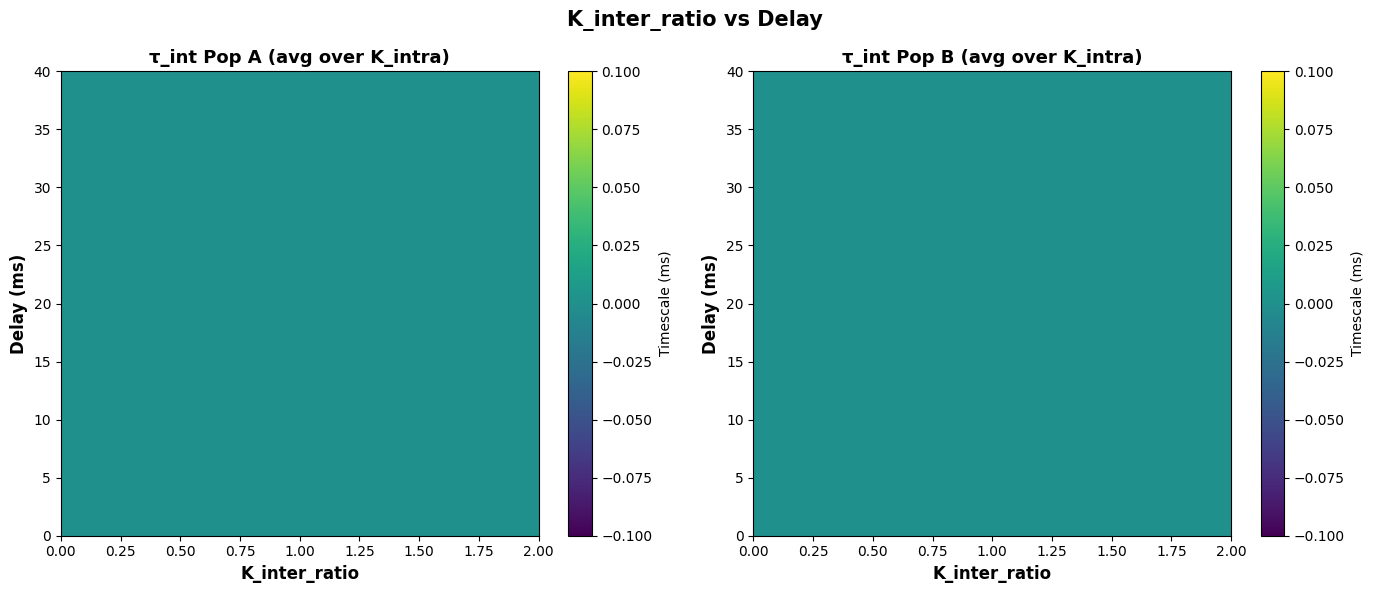

SUCCESS  | __main__:plot_kinter_vs_tau:97 - K_inter vs tau plot saved: kinter_vs_delay_tau.png


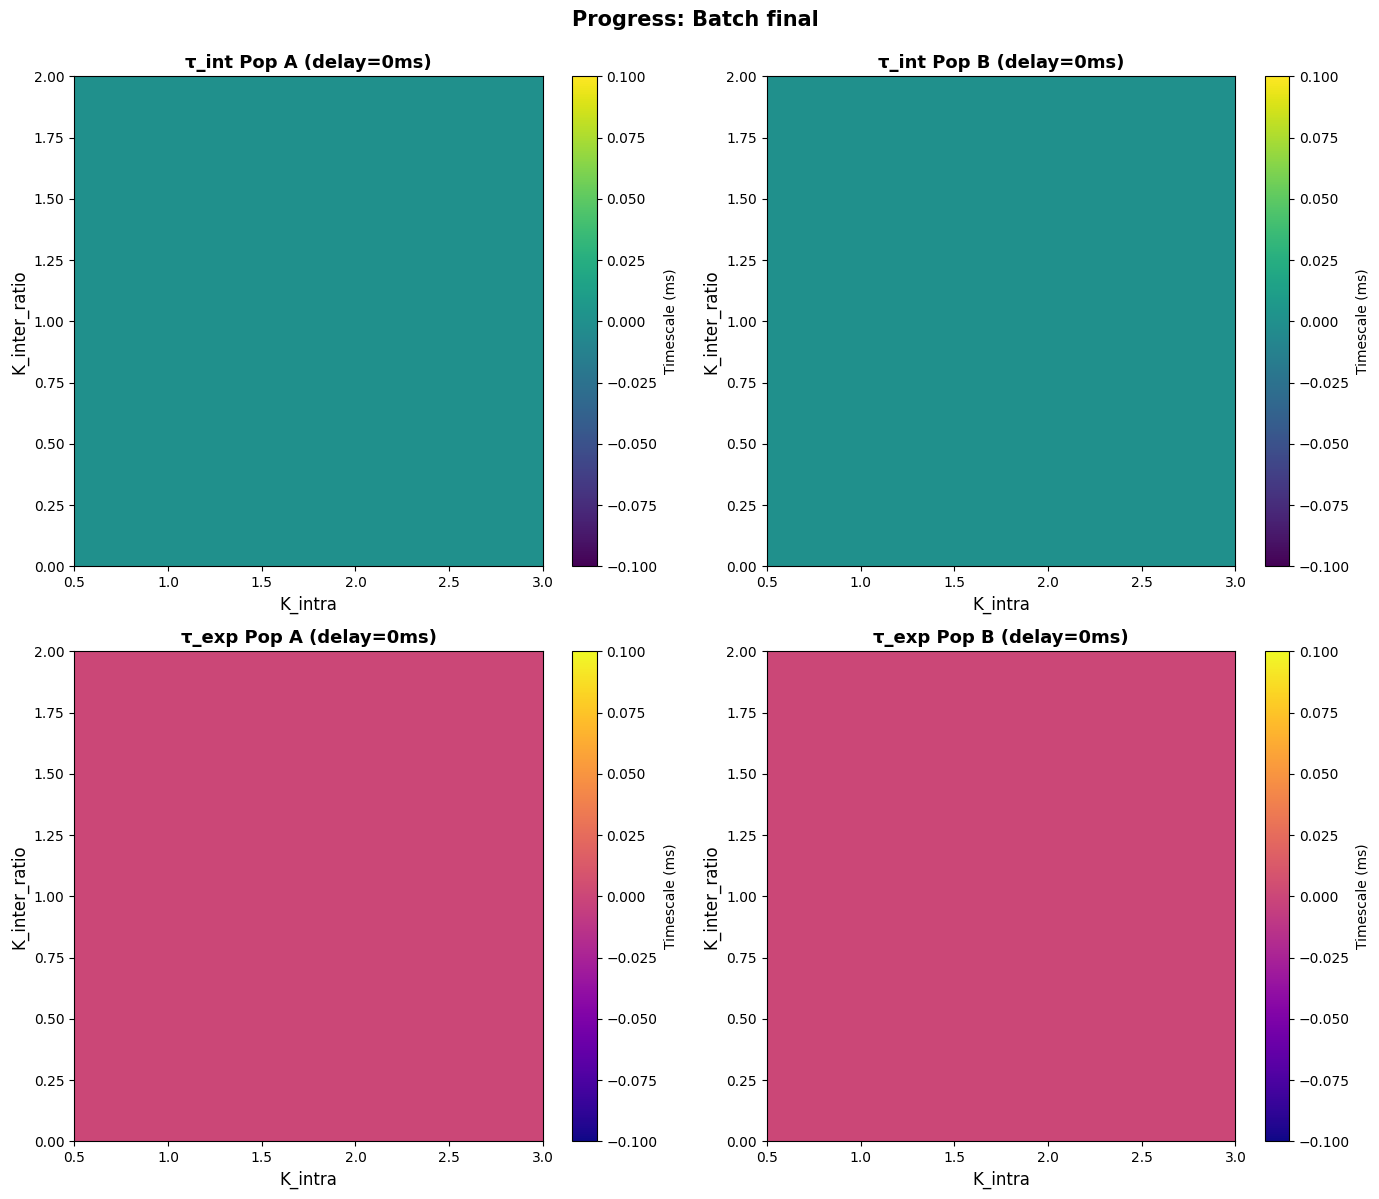

INFO     | __main__:plot_progress_heatmaps:66 - Progress plot saved: heatmap_delay0_batchfinal.png


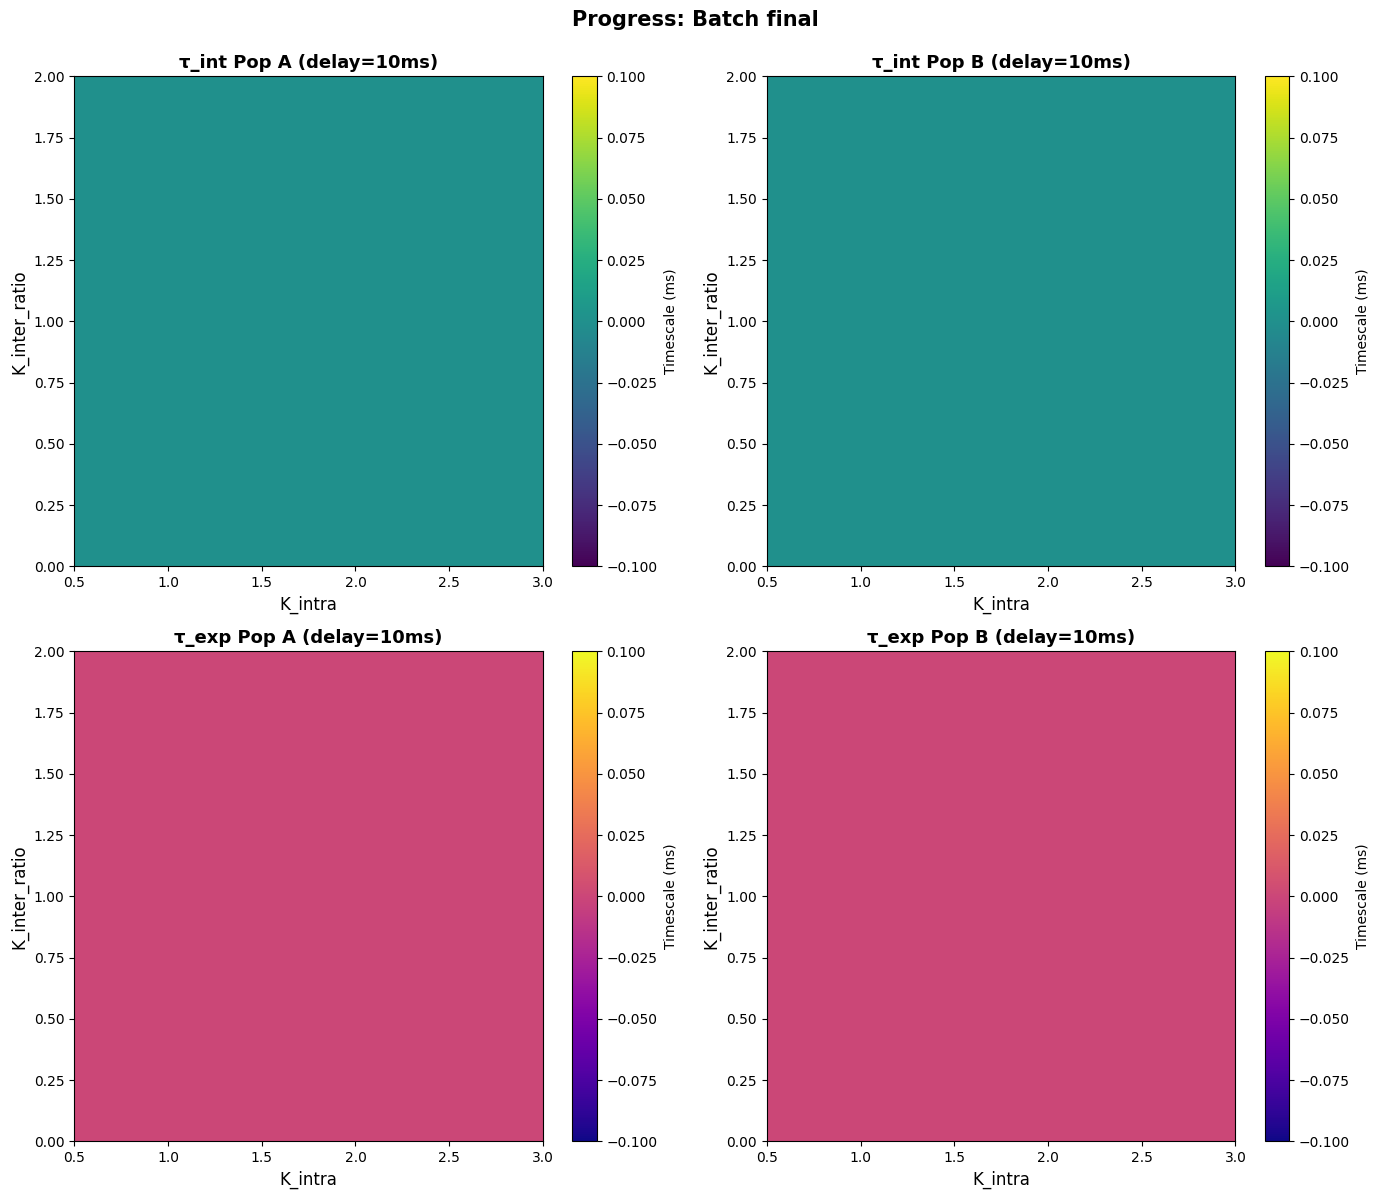

INFO     | __main__:plot_progress_heatmaps:66 - Progress plot saved: heatmap_delay10_batchfinal.png


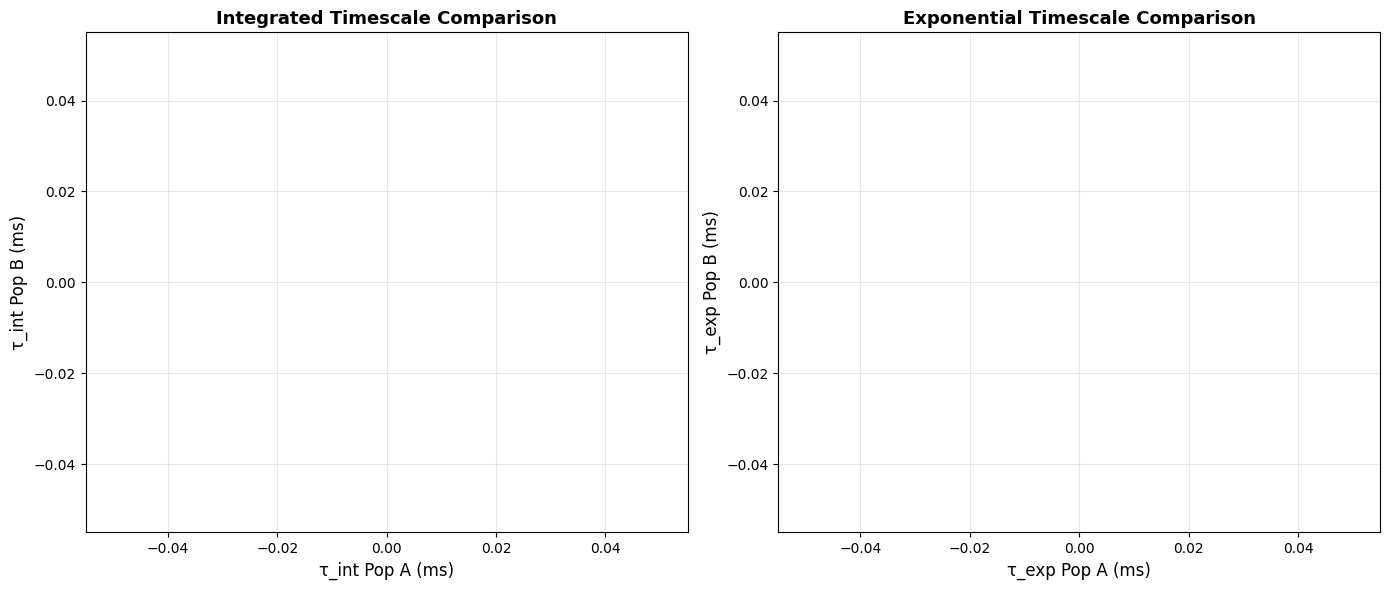

WARNING    /home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]


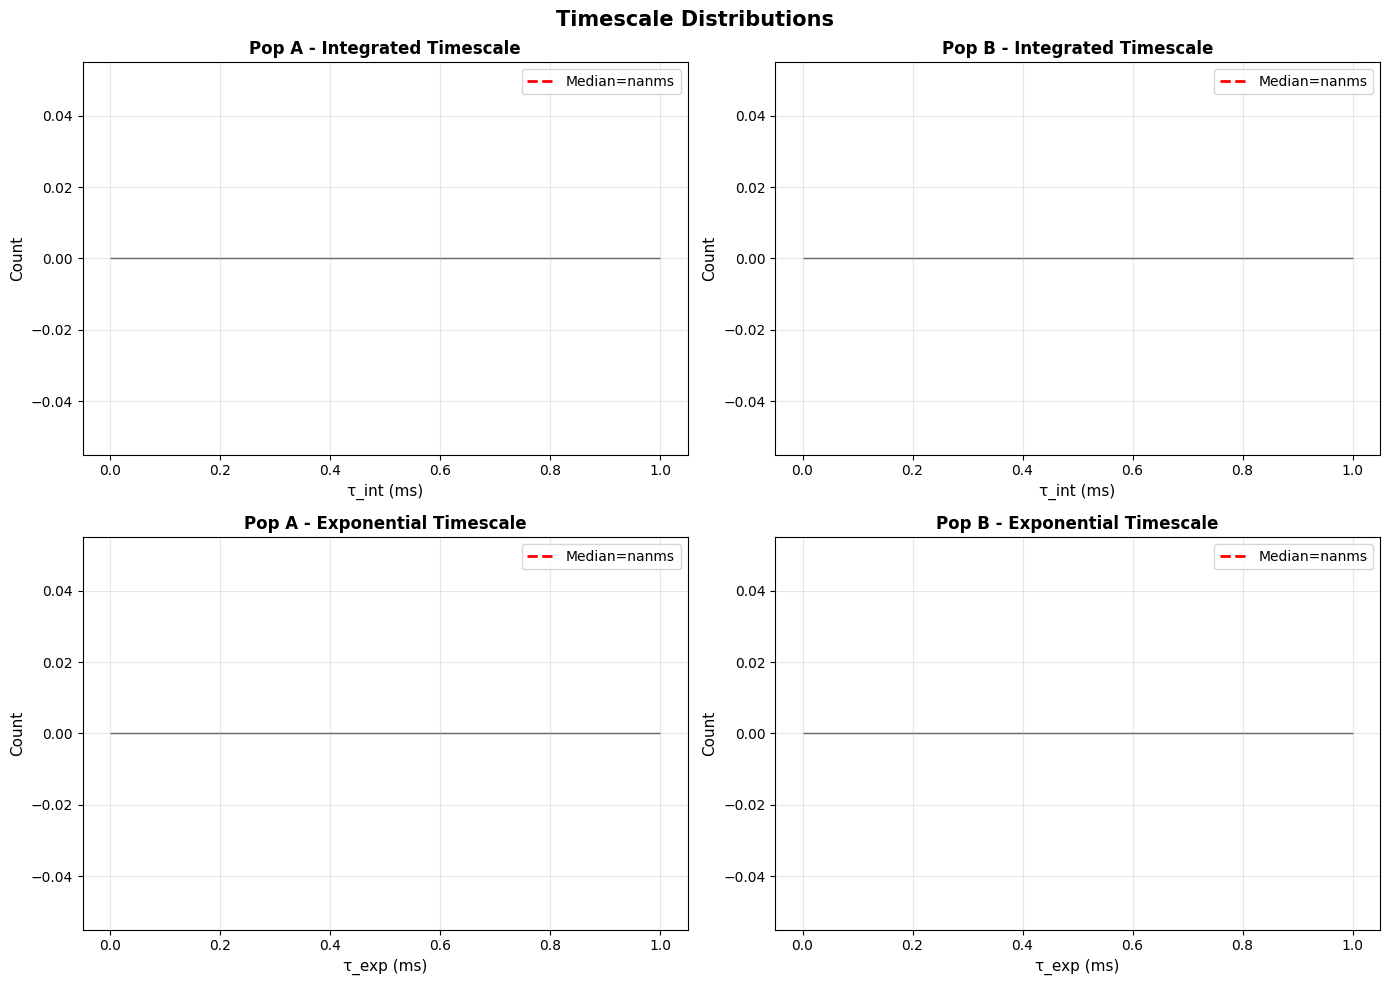

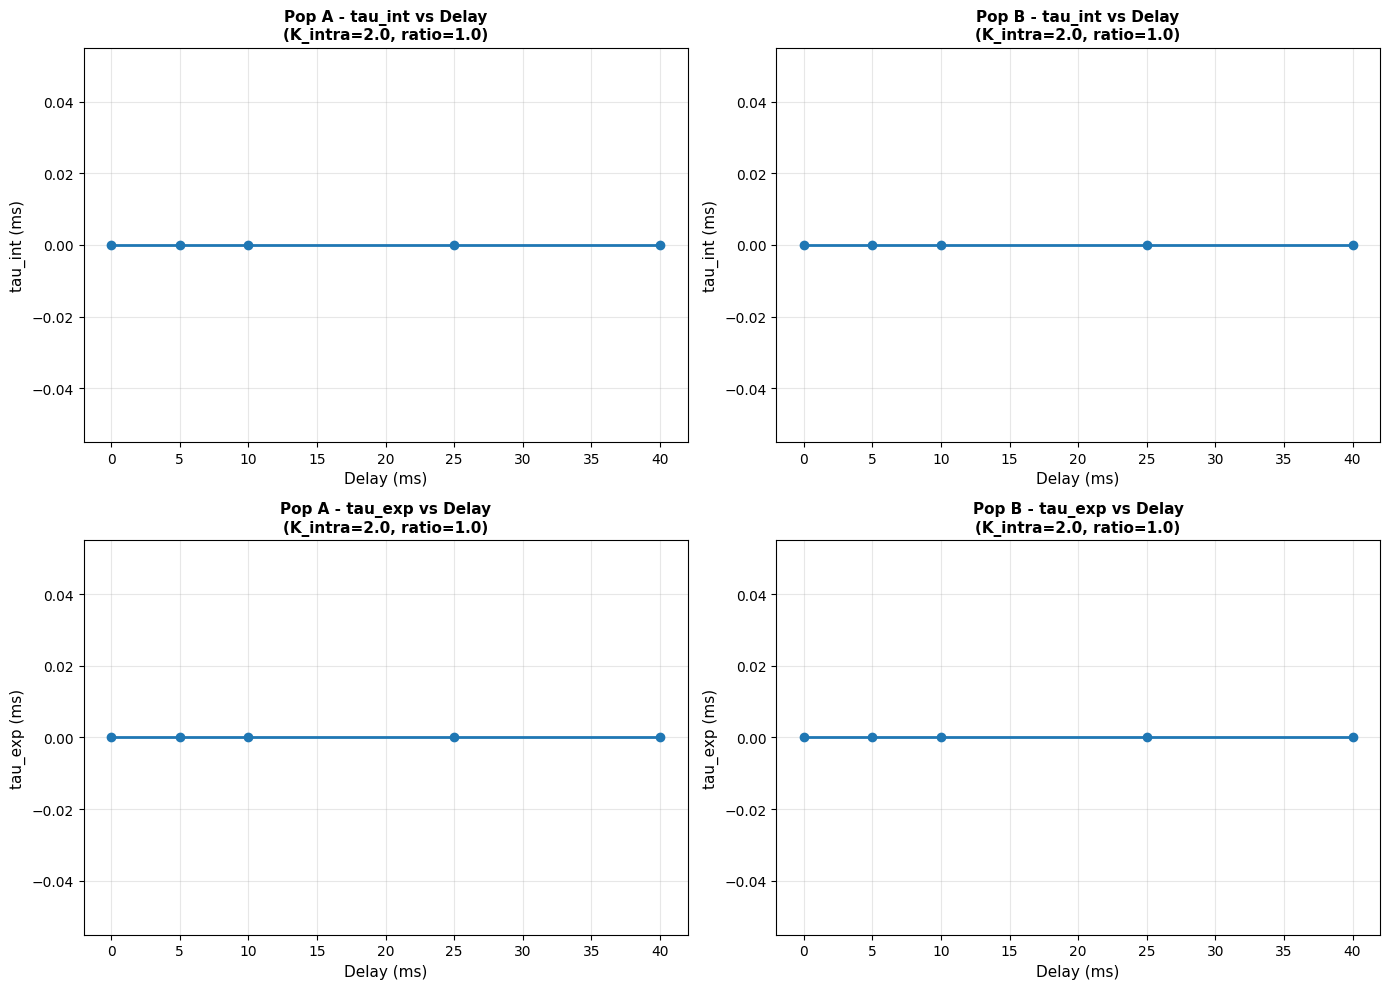

SUCCESS  | __main__:plot_final_dashboard:118 - Final dashboard completed


In [ ]:
# =============================================================================
# DASHBOARD FINAL COMPLETO
# =============================================================================

def plot_final_dashboard(arrays_3d, output_dir):
    """
    Dashboard completo con múltiples visualizaciones.
    """
    
    # 1. K_inter vs tau (ya implementado)
    plot_kinter_vs_tau(arrays_3d, output_dir)
    plt.show()
    
    # 2. Heatmaps 2D para delays seleccionados
    selected_delays = [0, 10, 30, 50] if 50 in DELAY_VALUES else [0, 10, 30]
    
    for delay_val in selected_delays:
        if delay_val not in DELAY_VALUES:
            continue
        delay_idx = np.where(DELAY_VALUES == delay_val)[0][0]
        plot_progress_heatmaps(arrays_3d, delay_idx, output_dir, "final")
        plt.show()
        
    # 3. Comparación tau_A vs tau_B
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # tau_int
    ax = axes[0]
    tau_A = arrays_3d['tau_int_A'].flatten()
    tau_B = arrays_3d['tau_int_B'].flatten()
    valid = (tau_A > 0) & (tau_B > 0)
    ax.scatter(tau_A[valid], tau_B[valid], alpha=0.3, s=10)
    ax.plot([0, np.max([tau_A.max(), tau_B.max()])], [0, np.max([tau_A.max(), tau_B.max()])], 'r--', alpha=0.5)
    ax.set_xlabel('τ_int Pop A (ms)', fontsize=12)
    ax.set_ylabel('τ_int Pop B (ms)', fontsize=12)
    ax.set_title('Integrated Timescale Comparison', fontsize=13, weight='bold')
    ax.grid(alpha=0.3)
    
    # # tau_exp
    # ax = axes[1]
    # tau_A = arrays_3d['tau_exp_A'].flatten()
    # tau_B = arrays_3d['tau_exp_B'].flatten()
    # valid = (tau_A > 0) & (tau_B > 0)
    # ax.scatter(tau_A[valid], tau_B[valid], alpha=0.3, s=10, color='orange')
    # ax.plot([0, np.max([tau_A.max(), tau_B.max()])], [0, np.max([tau_A.max(), tau_B.max()])], 'r--', alpha=0.5)
    # ax.set_xlabel('τ_exp Pop A (ms)', fontsize=12)
    # ax.set_ylabel('τ_exp Pop B (ms)', fontsize=12)
    # ax.set_title('Exponential Timescale Comparison', fontsize=13, weight='bold')
    # ax.grid(alpha=0.3)
    
    # plt.tight_layout()
    # plt.show()
    # plt.savefig(output_dir / "tau_comparison_A_vs_B.png", dpi=200, bbox_inches='tight')
    # plt.close()
    
    # 4. Histogramas de distribución
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for idx, (pop, color) in enumerate([('A', 'steelblue'), ('B', 'darkorange')]):
        # tau_int
        ax = axes[0, idx]
        data = arrays_3d[f'tau_int_{pop}'].flatten()
        data = data[data > 0]
        ax.hist(data, bins=50, alpha=0.7, color=color, edgecolor='black')
        ax.axvline(np.median(data), color='red', linestyle='--', linewidth=2, label=f'Median={np.median(data):.1f}ms')
        ax.set_xlabel('τ_int (ms)', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_title(f'Pop {pop} - Integrated Timescale', fontsize=12, weight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        
        # tau_exp
        ax = axes[1, idx]
        data = arrays_3d[f'tau_exp_{pop}'].flatten()
        data = data[data > 0]
        ax.hist(data, bins=50, alpha=0.7, color=color, edgecolor='black')
        ax.axvline(np.median(data), color='red', linestyle='--', linewidth=2, label=f'Median={np.median(data):.1f}ms')
        ax.set_xlabel('τ_exp (ms)', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_title(f'Pop {pop} - Exponential Timescale', fontsize=12, weight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.suptitle('Timescale Distributions', fontsize=15, weight='bold')
    plt.tight_layout()
    plt.show()
    plt.savefig(output_dir / "tau_distributions.png", dpi=200, bbox_inches='tight')
    plt.close()
    
    # 5. Dependencia con delay (para K_intra y K_inter fijos)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Seleccionar casos representativos
    k_intra_idx = len(K_INTRA_VALUES) // 2  # medio
    k_inter_idx = len(K_INTER_RATIOS) // 2
    
    for row, metric in enumerate(['tau_int', 'tau_exp']):
        for col, pop in enumerate(['A', 'B']):
            ax = axes[row, col]
            
            data = arrays_3d[f'{metric}_{pop}'][k_intra_idx, k_inter_idx, :]
            std = arrays_3d[f'{metric}_{pop}_std'][k_intra_idx, k_inter_idx, :]
            
            ax.plot(DELAY_VALUES, data, 'o-', linewidth=2, markersize=6)
            ax.fill_between(DELAY_VALUES, data - std, data + std, alpha=0.3)
            
            ax.set_xlabel('Delay (ms)', fontsize=11)
            ax.set_ylabel(f'{metric} (ms)', fontsize=11)
            ax.set_title(f'Pop {pop} - {metric} vs Delay\n(K_intra={K_INTRA_VALUES[k_intra_idx]:.1f}, ratio={K_INTER_RATIOS[k_inter_idx]:.1f})', 
                        fontsize=11, weight='bold')
            ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(output_dir / "tau_vs_delay.png", dpi=200, bbox_inches='tight')
    plt.close()
    
    logger.success("Final dashboard completed")

output_dir = Path(f"./results/sweep_3d_autocorr_20251201_164201")
# Ejecutar dashboard
plot_final_dashboard(arrays_3d, output_dir)

In [ ]:
# =============================================================================
# ANÁLISIS DE CASOS PARTICULARES
# =============================================================================

def analyze_particular_case(h5_file, sim_key, output_dir):
    """Análisis detallado de un caso particular"""
    threshold = 1/np.e  # ← AÑADIR ESTA LÍNEA
    
    with h5py.File(h5_file, 'r') as f:
        grp = f[sim_key]
        
        config_info = f"K_intra={grp.attrs['k_intra']:.2f}, ratio={grp.attrs['k_inter_ratio']:.2f}, delay={grp.attrs['delay_ms']:.0f}ms"
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        for idx, pop in enumerate(['A', 'B']):
            if pop not in grp['metrics']:
                continue
            
            pop_grp = grp['metrics'][pop]
            
            lags = pop_grp['ac_lags'][:]
            corr = pop_grp['ac_corr'][:]
            tau_exp = pop_grp.attrs['tau_exp']
            tau_int = pop_grp.attrs['tau_int']
            
            # Curva AC
            ax = axes[0, idx]
            ax.plot(lags, corr, 'k-', linewidth=2, label='Autocorrelation')
            
            # Exponential fit
            if tau_exp > 0:
                fit_lags = lags[lags >= 0]
                fit_exp = np.exp(-fit_lags / tau_exp)
                ax.plot(fit_lags, fit_exp, 'r--', linewidth=2, alpha=0.7, label=f'Exp fit: τ={tau_exp:.1f}ms')
            
            # Integrated area
            if tau_int > 0:
                pos_lags = lags >= 0
                pos_corr = corr[pos_lags]
                pos_lags_vals = lags[pos_lags]
                
                # Hasta cruce por 1/e
                threshold = 1/np.e
                cross_idx = np.where(pos_corr <= threshold)[0]
                if len(cross_idx) > 0:
                    end_idx = cross_idx[0]
                    ax.fill_between(pos_lags_vals[:end_idx], 0, pos_corr[:end_idx], 
                                   alpha=0.3, color='blue', label=f'Int: τ={tau_int:.1f}ms')
                    ax.axhline(threshold, color='gray', linestyle=':', alpha=0.5)
            
            ax.axhline(0, color='k', linestyle='--', alpha=0.3)
            ax.axvline(0, color='k', linestyle='-', alpha=0.3)
            ax.set_xlabel('Lag (ms)', fontsize=11)
            ax.set_ylabel('Autocorrelation', fontsize=11)
            ax.set_title(f'Pop {pop} - Autocorrelation\n{config_info}', fontsize=11, weight='bold')
            ax.legend(fontsize=9)
            ax.grid(alpha=0.3)
            ax.set_xlim(-50, 200)
            
            # Zoom en decay
            ax = axes[1, idx]
            ax.plot(lags, corr, 'k-', linewidth=2)
            if tau_exp > 0:
                ax.plot(fit_lags, fit_exp, 'r--', linewidth=2, alpha=0.7)
            ax.axhline(threshold, color='gray', linestyle=':', alpha=0.5, label='1/e threshold')
            ax.set_xlabel('Lag (ms)', fontsize=11)
            ax.set_ylabel('Autocorrelation', fontsize=11)
            ax.set_title(f'Pop {pop} - Decay Detail', fontsize=11, weight='bold')
            ax.legend(fontsize=9)
            ax.grid(alpha=0.3)
            ax.set_xlim(0, min(100, 5*max(tau_exp, tau_int)) if max(tau_exp, tau_int) > 0 else 100)
            ax.set_ylim(0, 1.1)
        
        plt.tight_layout()
        
        # Save
        case_name = f"k{grp.attrs['k_intra']:.1f}_r{grp.attrs['k_inter_ratio']:.1f}_d{grp.attrs['delay_ms']:.0f}"
        save_path = output_dir / "casos_particulares" / f"{case_name}_ac_detail.png"
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()
        
        logger.info(f"Particular case analyzed: {case_name}")


# Analizar casos: K_inter=0, delay=0, y otros identificados visualmente
particular_cases = [
    {'k_intra': 2.0, 'k_inter_ratio': 0.0, 'delay': 0},    # Sin acoplamiento
    {'k_intra': 0.5, 'k_inter_ratio': 0.0, 'delay': 0},    # Débil sin acoplamiento
    {'k_intra': 2.0, 'k_inter_ratio': 2.0, 'delay': 0},    # Fuerte acoplado instantáneo
    {'k_intra': 2.0, 'k_inter_ratio': 1.0, 'delay': 30},   # Moderado con delay
]

for case in particular_cases:
    # Buscar en HDF5 files
    for h5_file in sorted((output_dir / "raw_spikes").glob("batch_*.h5")):
        with h5py.File(h5_file, 'r') as f:
            for key in f.keys():
                grp = f[key]
                if (np.isclose(grp.attrs['k_intra'], case['k_intra'], atol=0.1) and
                    np.isclose(grp.attrs['k_inter_ratio'], case['k_inter_ratio'], atol=0.1) and
                    np.isclose(grp.attrs['delay_ms'], case['delay'], atol=0.1)):
                    
                    analyze_particular_case(h5_file, key, output_dir)
                    break

logger.success("Particular cases analysis completed")

INFO     | __main__:analyze_particular_case:83 - Particular case analyzed: k2.0_r0.0_d0
INFO     | __main__:analyze_particular_case:83 - Particular case analyzed: k0.5_r0.0_d0
INFO     | __main__:analyze_particular_case:83 - Particular case analyzed: k2.0_r2.0_d0
SUCCESS  | __main__:<module>:107 - Particular cases analysis completed


In [ ]:
# =============================================================================
# RESUMEN FINAL
# =============================================================================

summary_stats = {
    'timestamp': timestamp,
    'n_configs': n_configs,
    'n_total_sims': n_total_sims,
    'n_trials': SIM_CONFIG['n_trials'],
    'grid_shape': shape_3d,
    'tau_int_A': {
        'mean': float(np.mean(arrays_3d['tau_int_A'][arrays_3d['tau_int_A'] > 0])),
        'median': float(np.median(arrays_3d['tau_int_A'][arrays_3d['tau_int_A'] > 0])),
        'std': float(np.std(arrays_3d['tau_int_A'][arrays_3d['tau_int_A'] > 0])),
        'min': float(np.min(arrays_3d['tau_int_A'][arrays_3d['tau_int_A'] > 0])),
        'max': float(np.max(arrays_3d['tau_int_A'][arrays_3d['tau_int_A'] > 0]))
    },
    'tau_int_B': {
        'mean': float(np.mean(arrays_3d['tau_int_B'][arrays_3d['tau_int_B'] > 0])),
        'median': float(np.median(arrays_3d['tau_int_B'][arrays_3d['tau_int_B'] > 0])),
        'std': float(np.std(arrays_3d['tau_int_B'][arrays_3d['tau_int_B'] > 0])),
        'min': float(np.min(arrays_3d['tau_int_B'][arrays_3d['tau_int_B'] > 0])),
        'max': float(np.max(arrays_3d['tau_int_B'][arrays_3d['tau_int_B'] > 0]))
    },
    # 'tau_exp_A': {
    #     'mean': float(np.mean(arrays_3d['tau_exp_A'][arrays_3d['tau_exp_A'] > 0])),
    #     'median': float(np.median(arrays_3d['tau_exp_A'][arrays_3d['tau_exp_A'] > 0])),
    # },
    # 'tau_exp_B': {
    #     'mean': float(np.mean(arrays_3d['tau_exp_B'][arrays_3d['tau_exp_B'] > 0])),
    #     'median': float(np.median(arrays_3d['tau_exp_B'][arrays_3d['tau_exp_B'] > 0])),
    # }
}

with open(output_dir / "summary_statistics.json", 'w') as f:
    json.dump(summary_stats, f, indent=2)

logger.info("\n" + "="*70)
logger.success("SWEEP 3D COMPLETED")
logger.info("="*70)
logger.info(f"Output directory: {output_dir}")
logger.info(f"Total simulations: {n_total_sims}")
logger.info(f"τ_int Pop A: {summary_stats['tau_int_A']['mean']:.1f} ± {summary_stats['tau_int_A']['std']:.1f} ms")
logger.info(f"τ_int Pop B: {summary_stats['tau_int_B']['mean']:.1f} ± {summary_stats['tau_int_B']['std']:.1f} ms")
logger.info("="*70)

INFO     | __main__:<module>:38 - 
SUCCESS  | __main__:<module>:39 - SWEEP 3D COMPLETED
INFO     | __main__:<module>:40 - ======================================================================
INFO     | __main__:<module>:41 - Output directory: results/sweep_3d_autocorr_20251201_164201
INFO     | __main__:<module>:42 - Total simulations: 200
INFO     | __main__:<module>:43 - τ_int Pop A: 5.3 ± 3.7 ms
INFO     | __main__:<module>:44 - τ_int Pop B: 5.1 ± 3.7 ms
INFO     | __main__:<module>:45 - ======================================================================


In [17]:
# Crear directorio
(output_dir / "diagnostics").mkdir(exist_ok=True)

# Analizar fallidos
failed = analyze_failed_cases(output_dir)

# Plot top 3
for case in failed[:3]:
    plot_ac_diagnostic(output_dir / "raw_spikes" / case['file'], 
                      case['key'], output_dir / "diagnostics")

INFO     | __main__:analyze_failed_cases:182 - 
INFO     | __main__:analyze_failed_cases:183 - CASOS FALLIDOS (tau_exp < 1ms, tau_int > 5ms): 8
INFO     | __main__:analyze_failed_cases:184 - ============================================================
INFO     | __main__:analyze_failed_cases:187 - K=3.0, ratio=0.5, d=5ms
INFO     | __main__:analyze_failed_cases:188 -   tau_exp=0.000, tau_int=8.1, rate=11.9Hz
INFO     | __main__:analyze_failed_cases:187 - K=2.0, ratio=0.5, d=0ms
INFO     | __main__:analyze_failed_cases:188 -   tau_exp=0.000, tau_int=7.8, rate=9.9Hz
INFO     | __main__:analyze_failed_cases:187 - K=2.0, ratio=0.5, d=0ms
INFO     | __main__:analyze_failed_cases:188 -   tau_exp=0.000, tau_int=7.8, rate=9.8Hz
INFO     | __main__:analyze_failed_cases:187 - K=3.0, ratio=0.5, d=10ms
INFO     | __main__:analyze_failed_cases:188 -   tau_exp=0.000, tau_int=7.8, rate=11.4Hz
INFO     | __main__:analyze_failed_cases:187 - K=3.0, ratio=0.5, d=10ms
INFO     | __main__:analyze_failed_ca

INFO     | __main__:load_sweep_results:34 - Loaded 12 metrics from results/sweep_3d_autocorr_20251201_164201


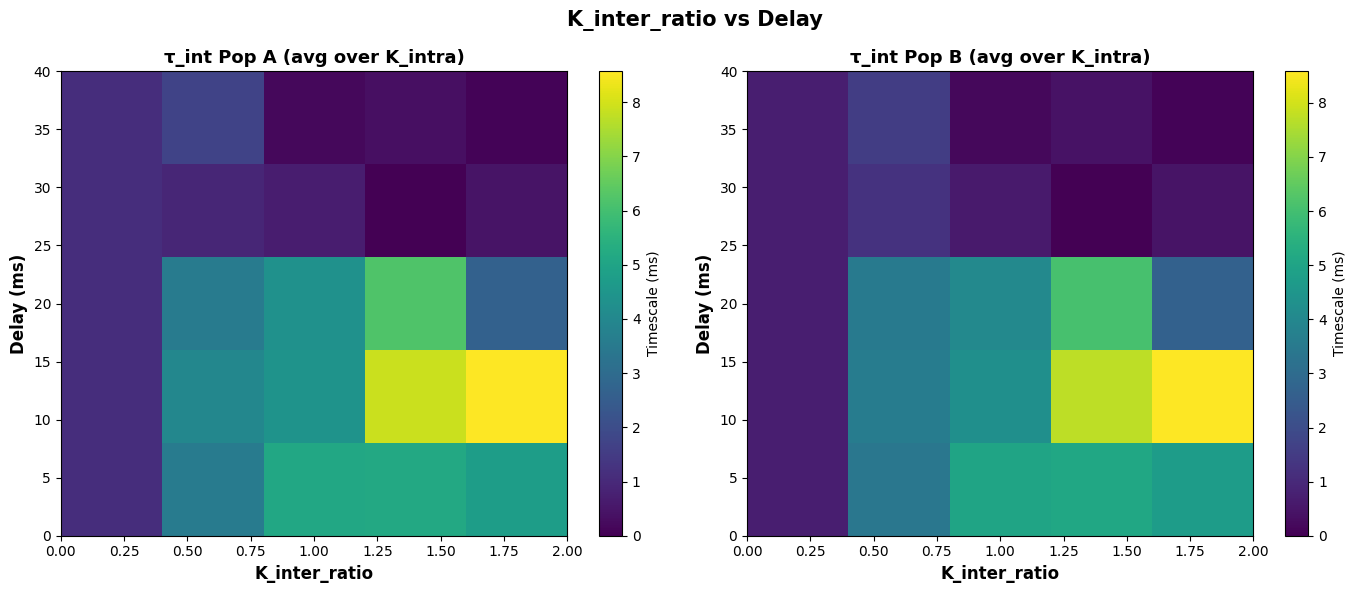

SUCCESS  | __main__:plot_kinter_vs_tau:97 - K_inter vs tau plot saved: kinter_vs_delay_tau.png


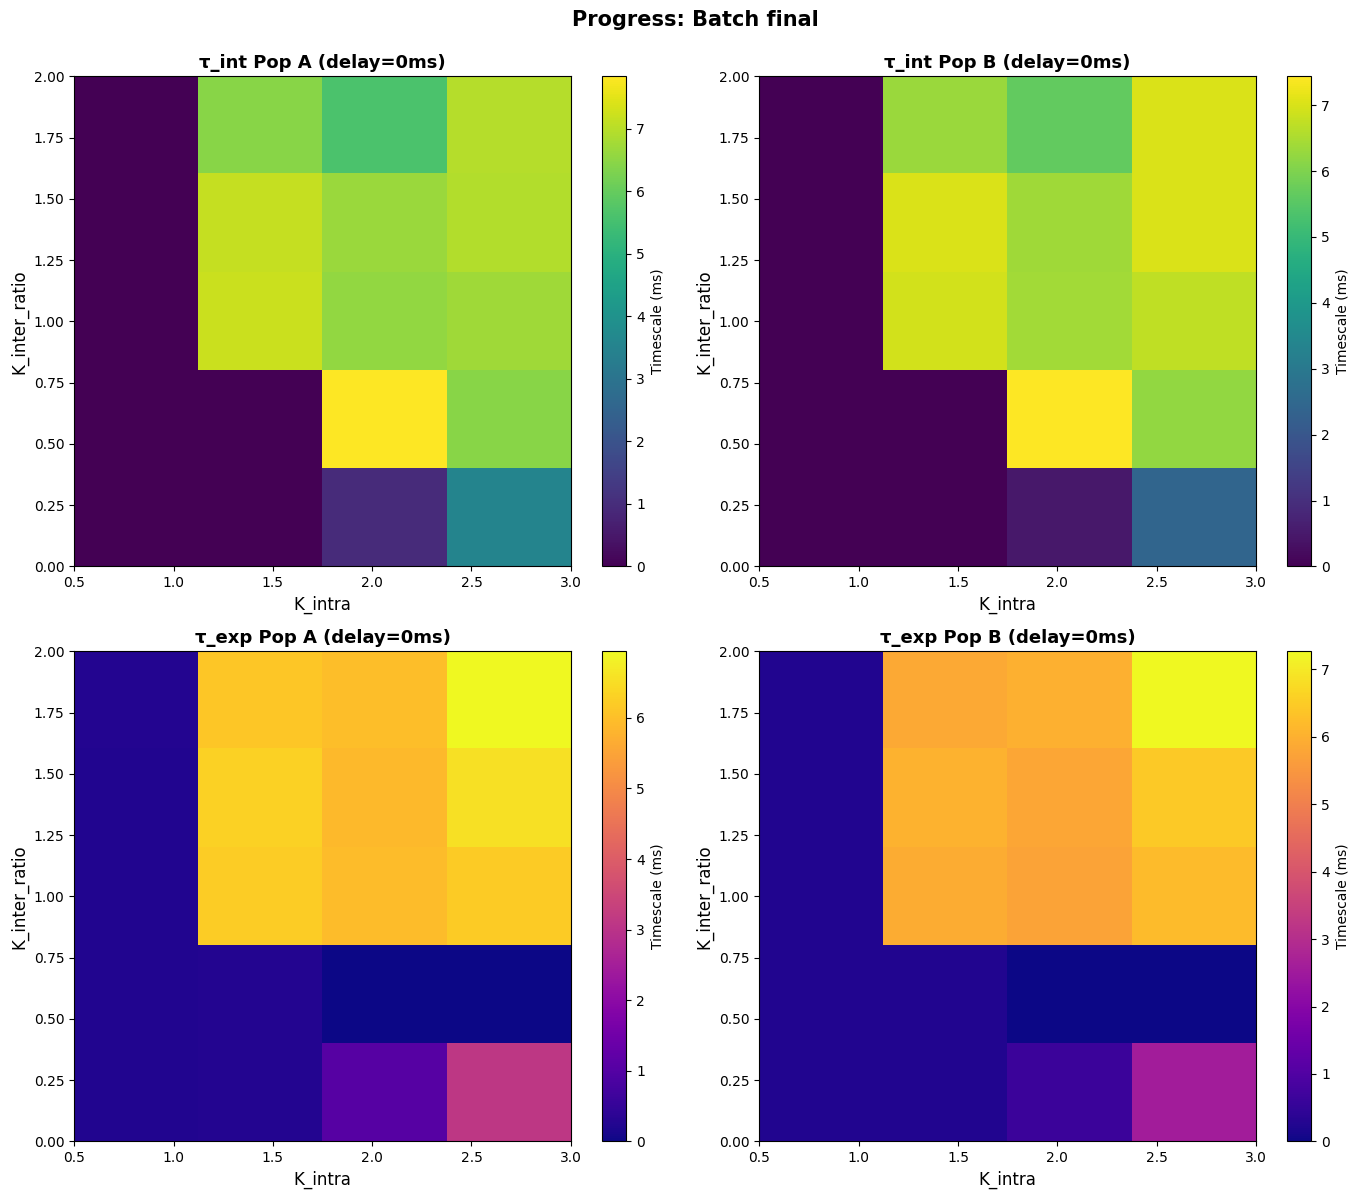

INFO     | __main__:plot_progress_heatmaps:66 - Progress plot saved: heatmap_delay0_batchfinal.png


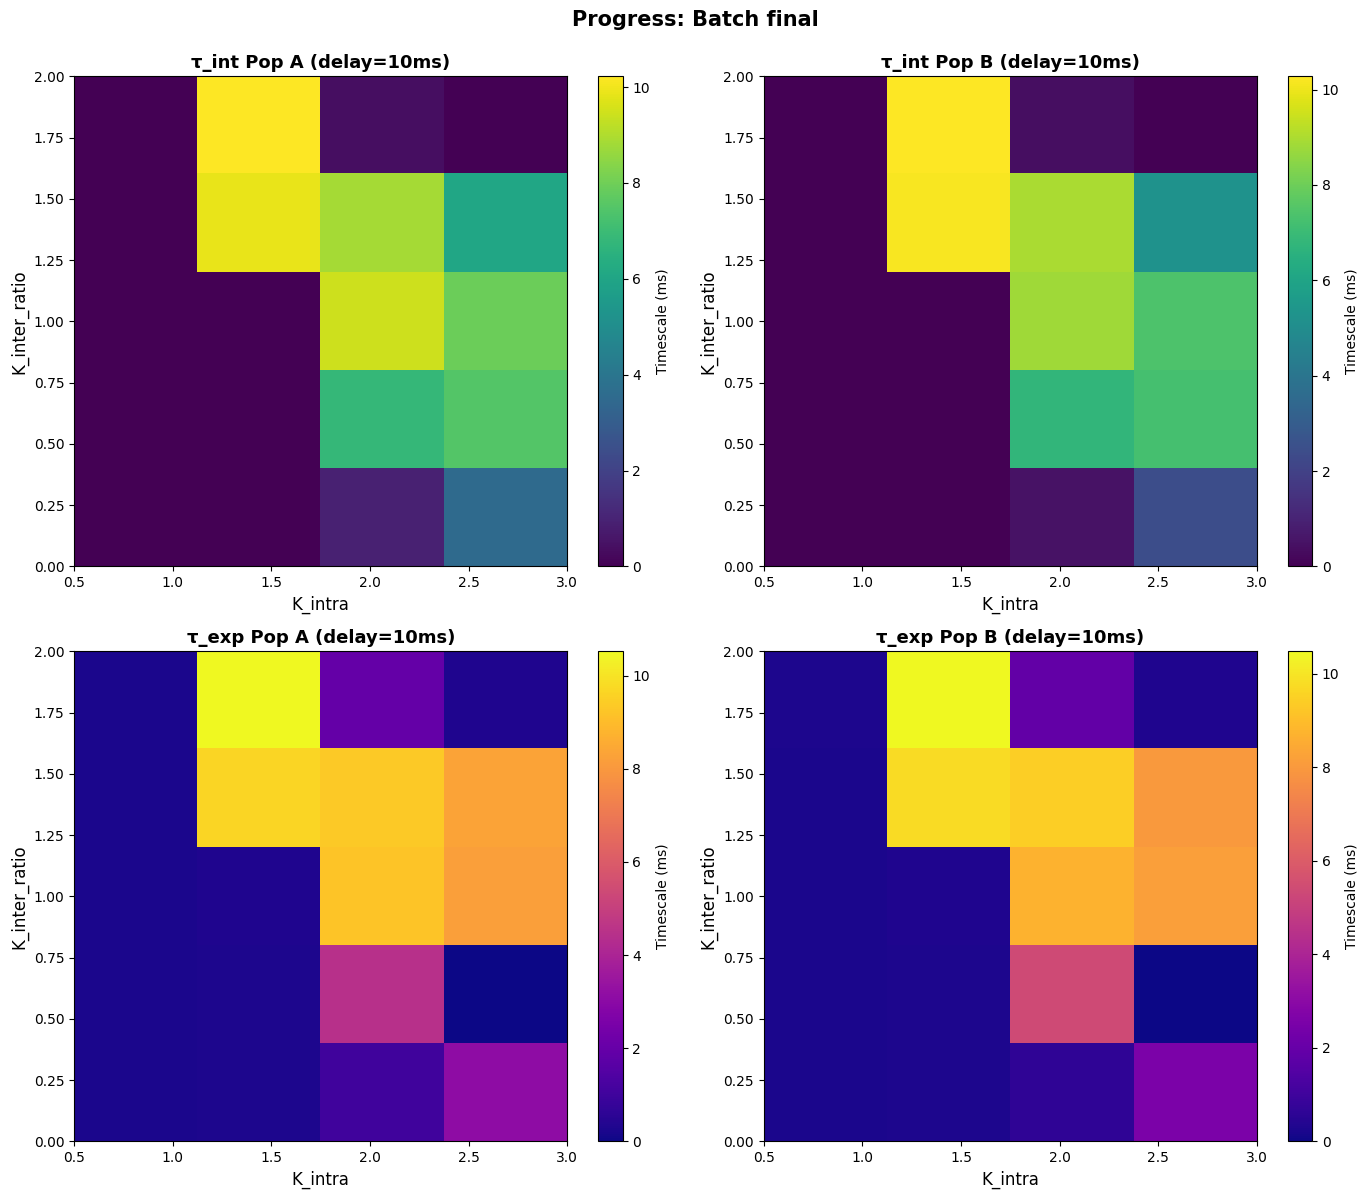

INFO     | __main__:plot_progress_heatmaps:66 - Progress plot saved: heatmap_delay10_batchfinal.png


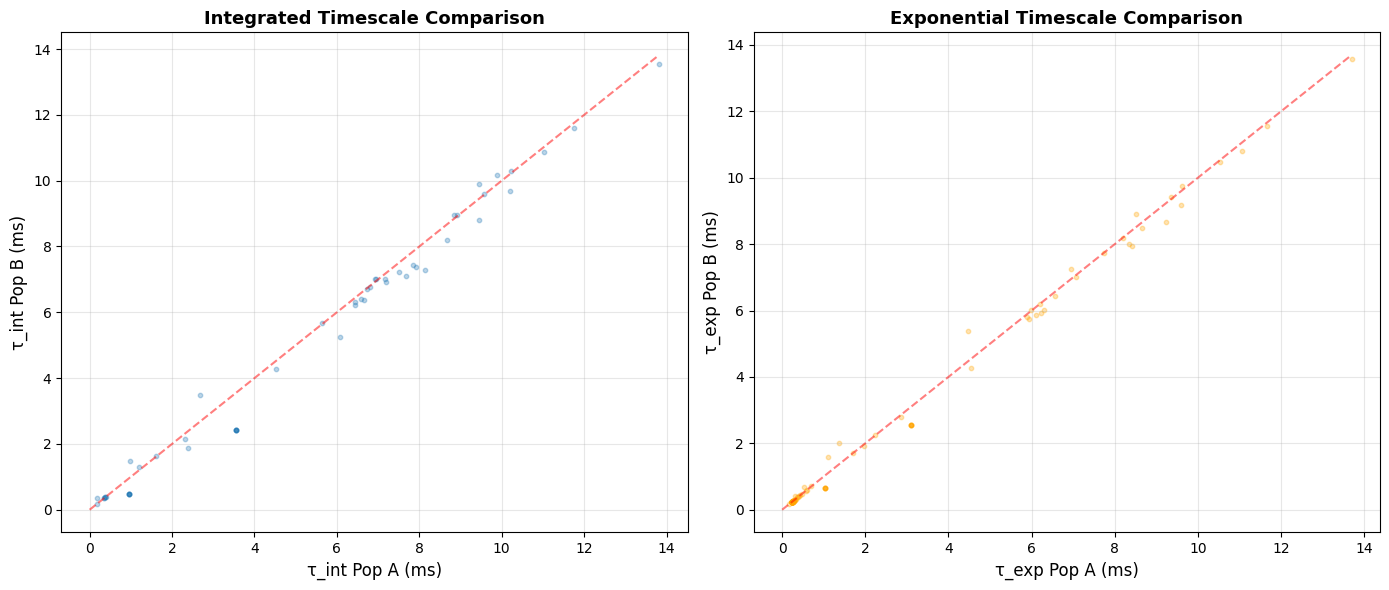

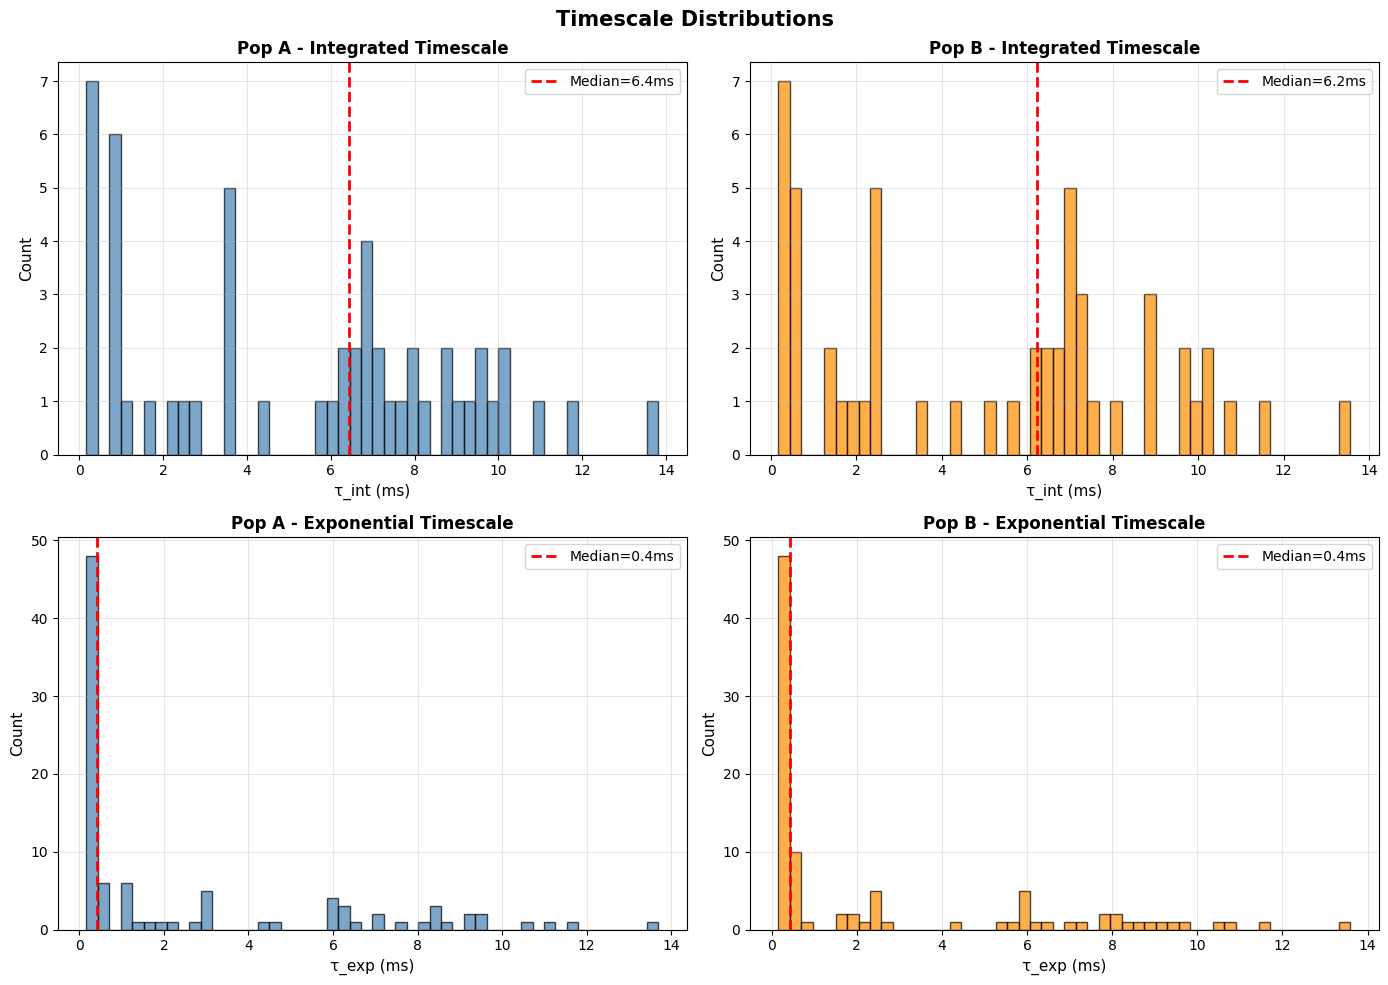

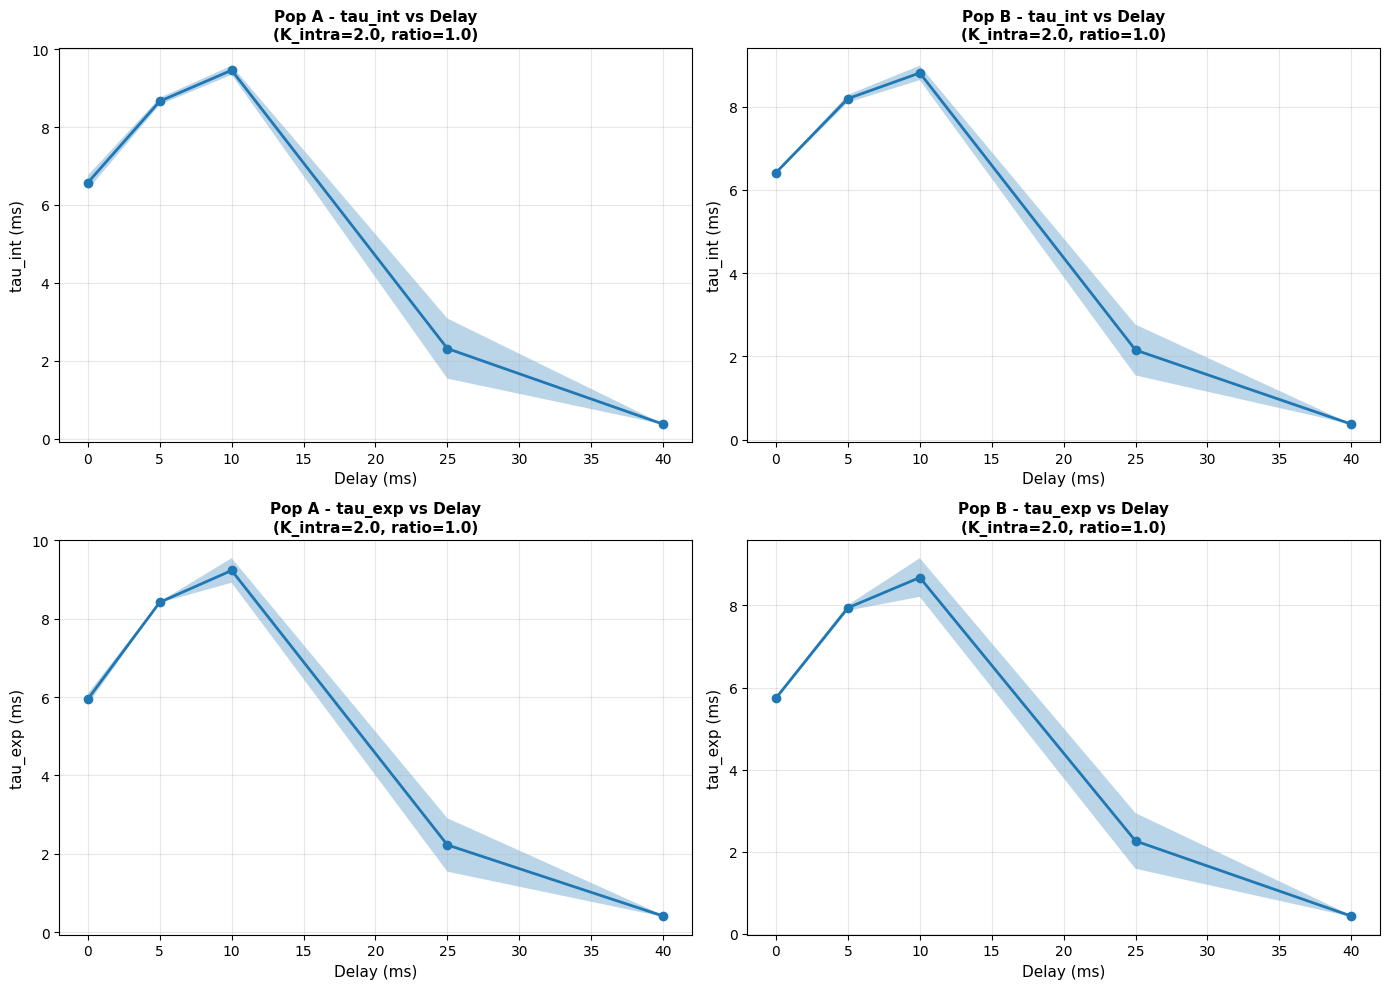

SUCCESS  | __main__:plot_final_dashboard:118 - Final dashboard completed


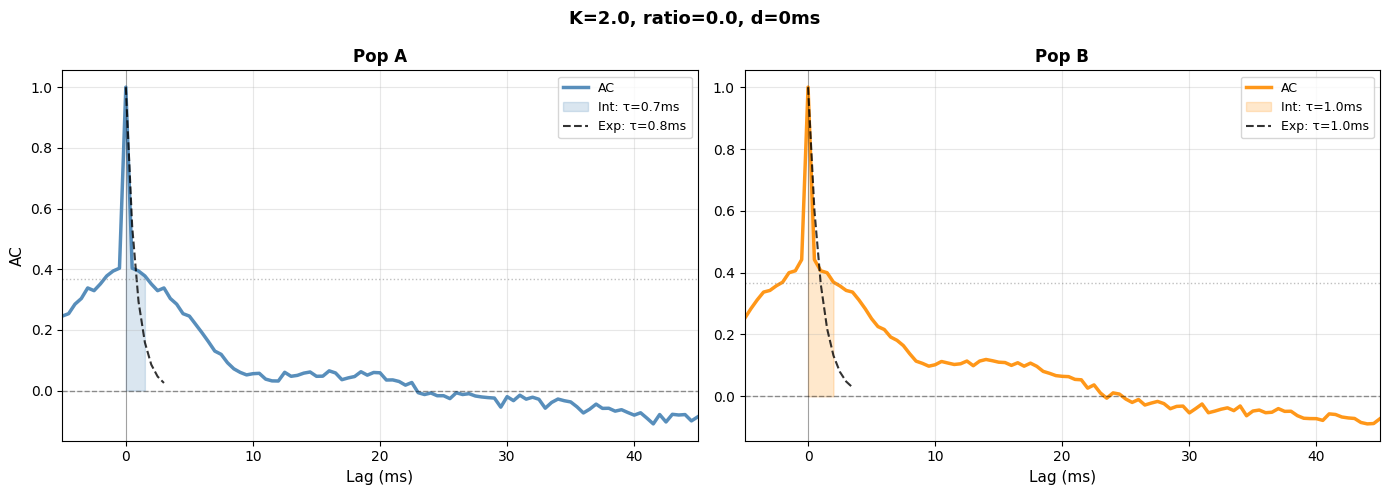

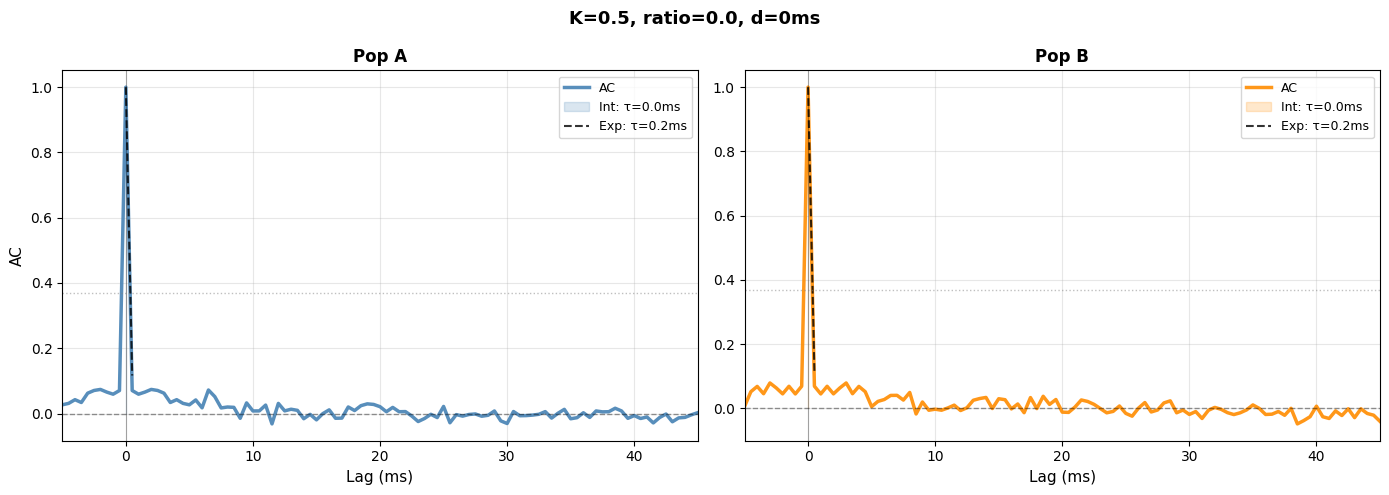

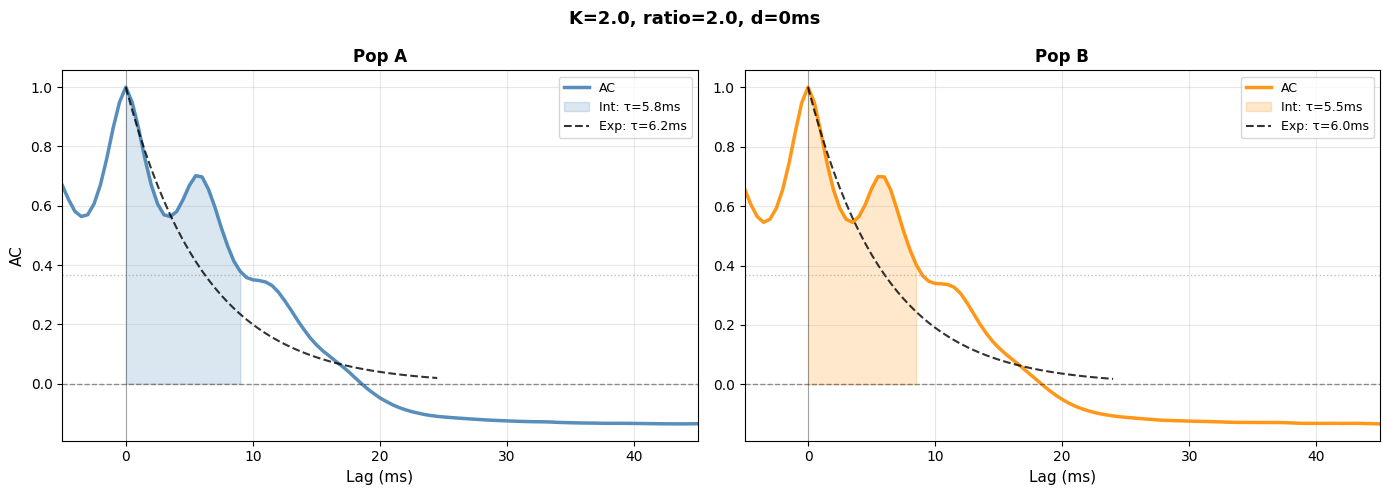

In [24]:
# =============================================================================
# FUNCIONES DE RECUPERACIÓN Y RE-PLOT
# =============================================================================

def load_and_replot_all(sweep_dir):
    """Cargar resultados y regenerar todos los plots"""
    
    # Cargar arrays 3D
    arrays_3d, config = load_sweep_results(sweep_dir)
    # Actualizar globals para plot_final_dashboard
    global K_INTRA_VALUES, K_INTER_RATIOS, DELAY_VALUES
    K_INTRA_VALUES = np.array(config['k_intra_values'])
    K_INTER_RATIOS = np.array(config['k_inter_ratios'])
    DELAY_VALUES = np.array(config['delay_values'])
    
    # Ejecutar dashboard existente
    plot_final_dashboard(arrays_3d, sweep_dir)
    
    return arrays_3d

def load_sweep_results(output_dir):
    """Cargar arrays 3D guardados"""
    metrics_dir = output_dir / "metrics_3d"
    
    arrays_3d = {}
    for metric_file in metrics_dir.glob("*.npy"):
        metric_name = metric_file.stem
        arrays_3d[metric_name] = np.load(metric_file)
    
    # Cargar config
    with open(output_dir / "config.json", 'r') as f:
        config = json.load(f)
    
    logger.info(f"Loaded {len(arrays_3d)} metrics from {output_dir}")
    return arrays_3d, config



# Casos particulares estilizados (función nueva)
def plot_particular_cases_styled(output_dir, cases_list):
    """Plot AC casos particulares con estilo dashboard"""
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    for case in cases_list:
        # Buscar en HDF5
        case_data = None
        for h5_file in sorted((output_dir / "raw_spikes").glob("batch_*.h5")):
            with h5py.File(h5_file, 'r') as f:
                for key in f.keys():
                    grp = f[key]
                    if (np.isclose(grp.attrs['k_intra'], case['k_intra'], atol=0.1) and
                        np.isclose(grp.attrs['k_inter_ratio'], case['k_inter_ratio'], atol=0.1) and
                        np.isclose(grp.attrs['delay_ms'], case['delay'], atol=0.1)):
                        case_data = (h5_file, key)
                        break
            if case_data:
                break
        
        if not case_data:
            logger.warning(f"Case not found: {case}")
            continue
        
        # Cargar y plotear
        with h5py.File(case_data[0], 'r') as f:
            grp = f[case_data[1]]
            case_info = f"K={grp.attrs['k_intra']:.1f}, ratio={grp.attrs['k_inter_ratio']:.1f}, d={grp.attrs['delay_ms']:.0f}ms"
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            for idx, pop in enumerate(['A', 'B']):
                ax = axes[idx]
                lags = grp[f'metrics/{pop}/ac_lags'][:]
                corr = grp[f'metrics/{pop}/ac_corr'][:]
                tau_exp = grp[f'metrics/{pop}'].attrs['tau_exp']
                tau_int = grp[f'metrics/{pop}'].attrs['tau_int']
                
                mask = (lags >= -5) & (lags <= 45)
                ax.plot(lags[mask], corr[mask], lw=2.5, alpha=0.9, color=colors[pop], label='AC')
                
                pos = (lags >= 0) & (lags <= 45)
                zero_idx = np.where(corr[pos] <= 1/np.e)[0]
                if len(zero_idx) > 0:
                    ax.fill_between(lags[pos][:zero_idx[0]], 0, corr[pos][:zero_idx[0]], 
                                   alpha=0.2, color=colors[pop], label=f'Int: τ={tau_int:.1f}ms')
                
                if not np.isnan(tau_exp) and tau_exp > 0:
                    fit_x = lags[pos][(lags[pos] <= min(4*tau_exp, 45))]
                    if len(fit_x) > 0:
                        fit_y = np.exp(-fit_x / tau_exp)
                        ax.plot(fit_x, fit_y, 'k--', lw=1.5, alpha=0.8, label=f'Exp: τ={tau_exp:.1f}ms')
                
                ax.axhline(0, color='k', ls='--', lw=1, alpha=0.4)
                ax.axvline(0, color='k', ls='-', lw=0.8, alpha=0.3)
                ax.axhline(1/np.e, color='gray', ls=':', lw=1, alpha=0.5)
                ax.set_xlabel('Lag (ms)', fontsize=11)
                if idx == 0:
                    ax.set_ylabel('AC', fontsize=11)
                ax.set_title(f'Pop {pop}', fontsize=12, weight='bold')
                ax.legend(fontsize=9, loc='upper right')
                ax.grid(True, alpha=0.3)
                ax.set_xlim(-5, 45)
            
            fig.suptitle(case_info, fontsize=13, weight='bold')
            plt.tight_layout()
            plt.show()
            plt.savefig(output_dir / "casos_particulares" / f"k{case['k_intra']:.1f}_r{case['k_inter_ratio']:.1f}_d{case['delay']:.0f}_styled.png", 
                       dpi=200, bbox_inches='tight')
            plt.close()


# USO
sweep_dir = Path("./results/sweep_3d_autocorr_20251201_164201")
arrays_3d = load_and_replot_all(sweep_dir)

# Casos particulares
particular_cases = [
    {'k_intra': 2.0, 'k_inter_ratio': 0.0, 'delay': 0},
    {'k_intra': 0.5, 'k_inter_ratio': 0.0, 'delay': 0},
    {'k_intra': 2.0, 'k_inter_ratio': 2.0, 'delay': 0}
]
plot_particular_cases_styled(sweep_dir, particular_cases)